<a href="https://colab.research.google.com/github/joe-granick/CS462/blob/main/GNN_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip list | grep torch

torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchsummary                       1.5.1
torchvision                        0.20.1+cu121


In [2]:
!pip install torch==2.0.1+cu117 torchvision==0.15.2+cu117 torchaudio==2.0.2+cu117 --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 883.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89991 sha256=0e69d51f86165425bb21532434ef996ea3980b804c554c40e64edc7591da52cc
  Stored in directory: /root/.cache/pip/wheels/27/2c/b6/3ed2983b1b44fe0dea1bb35234b09f2c22fb8ebb308679c922
Successfully built lit
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: torchvision
    Found existing 

In [3]:
!pip install torch-scatter==2.1.2+pt20cu117 \
    torch-sparse==0.6.18+pt20cu117 \
    torch-cluster==1.6.3+pt20cu117 \
    torch-spline-conv==1.2.2+pt20cu117 \
    -f https://data.pyg.org/whl/torch-2.0.0+cu117.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.2/887.2 kB 49.2 MB/s eta 0:00:00


In [4]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.6 MB/s eta 0:00:00


In [5]:
import torch
from torch_geometric.data import Data

print(torch.__version__)  # Should be 2.0.1+cu117
print(Data)  # Should import without errors

2.0.1+cu117
<class 'torch_geometric.data.data.Data'>


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import pandas as pd
from copy import deepcopy

In [8]:
# Example simulated dataset
ads = pd.DataFrame({
    "ad_id": [0, 1, 2, 3, 4],
    "category": ["sports", "sports", "fashion", "electronics", "fashion"],
    "brand": ["Nike", "Adidas", "Gucci", "Sony", "Gucci"],
    "clicked": [1, 0, 1, 0, 1]  # Labels: 1 for clicked, 0 for not clicked
})

# Create neighbors based on shared attributes
neighbors = {
    0: [1],  # Ad 0 shares "sports" category with Ad 1
    2: [4]   # Ad 2 shares "fashion" brand with Ad 4
}

# Edge list for graph representation
edge_index = []
for ad, neigh in neighbors.items():
    for n in neigh:
        edge_index.append([ad, n])
edge_index = torch.tensor(edge_index).t().contiguous()

# Features for ads (numerical encoding for category and brand)
ad_features = pd.get_dummies(ads[["category", "brand"]]).values
x = torch.tensor(ad_features, dtype=torch.float)

# Labels for ads
y = torch.tensor(ads["clicked"].values, dtype=torch.long)

print("Node Features:\n", x)
print("Edge Index:\n", edge_index)
print("Labels:\n", y)


Node Features:
 tensor([[0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0.]])
Edge Index:
 tensor([[0, 2],
        [1, 4]])
Labels:
 tensor([1, 0, 1, 0, 1])


In [9]:
class GMEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GMEModel, self).__init__()
        self.embedding_layer = nn.Linear(input_dim, hidden_dim)
        self.gat_layer = GATConv(hidden_dim, hidden_dim, heads=4, concat=True)
        self.fc_layer = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x, edge_index):
        x = self.embedding_layer(x)
        x = self.gat_layer(x, edge_index)
        x = self.fc_layer(x)
        return x


In [11]:
class MetaLearner:
    def __init__(self, model, meta_lr=0.001, task_lr=0.01):
        self.model = model
        self.meta_optimizer = optim.Adam(model.parameters(), lr=meta_lr)
        self.task_lr = task_lr

    def train_task(self, task_data):
        model_copy = deepcopy(self.model)
        optimizer = optim.SGD(model_copy.parameters(), lr=self.task_lr)

        # Task-specific training
        for batch in task_data:
            x, edge_index, y = batch
            optimizer.zero_grad()
            out = model_copy(x, edge_index)
            loss = nn.CrossEntropyLoss()(out, y)
            loss.backward()
            optimizer.step()
        return model_copy

    def meta_train(self, meta_data):
        for task in meta_data:
            task_model = self.train_task(task)
            meta_loss = self.evaluate_meta_loss(task_model, task)
            self.meta_optimizer.zero_grad()
            meta_loss.backward()
            self.meta_optimizer.step()

    def evaluate_meta_loss(self, model, task):
        x, edge_index, y = task
        out = model(x, edge_index)
        return nn.CrossEntropyLoss()(out, y)

In [12]:
# Prepare data
data = Data(x=x, edge_index=edge_index, y=y)

# Split data into tasks (train, validation, test)
train_task = Data(x=x[:3], edge_index=edge_index[:, :2], y=y[:3])  # First 3 nodes
val_task = Data(x=x[3:], edge_index=edge_index[:, 2:], y=y[3:])   # Last 2 nodes

# Initialize model and meta-learner
input_dim = x.shape[1]
hidden_dim = 16
output_dim = 2  # Binary classification (clicked or not)

model = GMEModel(input_dim, hidden_dim, output_dim)
meta_learner = MetaLearner(model)

# Meta-training
meta_learner.meta_train([train_task])

ValueError: not enough values to unpack (expected 3, got 2)

In [13]:
print("Node Features (x):", x.shape, x.dtype)  # Should be [num_nodes, feature_dim]
print("Edge Index (edge_index):", edge_index.shape, edge_index.dtype)  # [2, num_edges]
print("Labels (y):", y.shape, y.dtype)  # [num_nodes]


Node Features (x): torch.Size([5, 7]) torch.float32
Edge Index (edge_index): torch.Size([2, 2]) torch.int64
Labels (y): torch.Size([5]) torch.int64


In [15]:
import torch
from torch_geometric.data import Data

# Verify edge connections
print("Edge Index (edge connections):", edge_index)
print("Source Nodes:", edge_index[0])
print("Target Nodes:", edge_index[1])


Edge Index (edge connections): tensor([[0, 2],
        [1, 4]])
Source Nodes: tensor([0, 2])
Target Nodes: tensor([1, 4])


In [16]:
# Create masks for train and validation nodes
train_mask = torch.arange(3)  # Nodes 0, 1, 2
val_mask = torch.arange(3, len(x))  # Nodes 3, 4

# Function to filter edges for a given node mask
def filter_edges(edge_index, mask):
    mask_set = set(mask.tolist())
    edge_filter = [
        i for i, (src, tgt) in enumerate(edge_index.t().tolist())
        if src in mask_set and tgt in mask_set
    ]
    return edge_index[:, edge_filter]

# Filter edges for train and validation sets
train_edge_index = filter_edges(edge_index, train_mask)
val_edge_index = filter_edges(edge_index, val_mask)

# Define train and validation tasks
train_task = Data(
    x=x[train_mask],
    edge_index=train_edge_index,
    y=y[train_mask]
)
val_task = Data(
    x=x[val_mask],
    edge_index=val_edge_index,
    y=y[val_mask]

)

# Print results for verification
print("Train Task Edges:", train_task.edge_index)
print("Validation Task Edges:", val_task.edge_index)


Train Task Edges: tensor([[0],
        [1]])
Validation Task Edges: tensor([], size=(2, 0), dtype=torch.int64)


In [17]:
import torch
from torch_geometric.data import Data

# Example: Ads and relationships based on shared attributes
node_features = torch.tensor([[0.2, 0.3],  # Ad 1 features
                               [0.5, 0.1],  # Ad 2 features
                               [0.6, 0.8],  # Ad 3 features
                               [0.1, 0.4],  # Ad 4 features
                               [0.9, 0.7]]) # Ad 5 features

edge_index = torch.tensor([[0, 1, 2, 3],  # Source nodes
                           [1, 2, 3, 4]]) # Target nodes

labels = torch.tensor([1, 0, 1, 0, 1])  # Clicked (1) or not (0)

data = Data(x=node_features, edge_index=edge_index, y=labels)


In [18]:
# Add synthetic edges between nodes 3 and 4
augmented_edge_index = torch.cat([edge_index, torch.tensor([[3, 4], [4, 3]])], dim=1)

train_task = Data(x=node_features[train_mask], edge_index=augmented_edge_index, y=labels[train_mask])
val_task = Data(x=node_features[val_mask], edge_index=augmented_edge_index, y=labels[val_mask])


In [19]:
import torch.nn as nn
from torch_geometric.nn import GATConv

class AdRecommenderGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AdRecommenderGNN, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=4, concat=True)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = nn.functional.elu(x)
        x = self.gat2(x, edge_index)
        x = nn.functional.elu(x)
        return self.fc(x)

In [20]:
model = AdRecommenderGNN(input_dim=2, hidden_dim=16, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    output = model(train_task.x, train_task.edge_index).squeeze()
    loss = criterion(output, train_task.y.float())
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


IndexError: Found indices in 'edge_index' that are larger than 2 (got 4). Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 3) in your node feature matrix and try again.

In [21]:
# Augmented Edge Index: Includes nodes 3 and 4
augmented_edge_index = torch.cat([edge_index, torch.tensor([[3, 4], [4, 3]])], dim=1)

# Identify all nodes in augmented_edge_index
nodes_in_augmented_graph = torch.unique(augmented_edge_index)

# Create a new x and y for the augmented graph
augmented_x = node_features[nodes_in_augmented_graph]
augmented_y = labels[nodes_in_augmented_graph]

# Map old indices to new compact indices (necessary for GNNs)
node_map = {old_idx: new_idx for new_idx, old_idx in enumerate(nodes_in_augmented_graph.tolist())}
mapped_edge_index = torch.tensor(
    [[node_map[old_idx] for old_idx in row] for row in augmented_edge_index.tolist()]
).T

# Define train_task with augmented nodes and edges
train_task = Data(x=augmented_x, edge_index=mapped_edge_index, y=augmented_y)

In [23]:
model = AdRecommenderGNN(input_dim=2, hidden_dim=16, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    output = model(train_task.x, train_task.edge_index).squeeze()
    loss = criterion(output, train_task.y.float())
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 6 but got size 2 for tensor number 1 in the list.

In [25]:
print("Node Features Shape:", train_task.x.shape)
print("Edge Index Shape:", train_task.edge_index.shape)
print("Labels Shape:", train_task.y.shape)
print("Max Node Index in Edges:", train_task.edge_index.max().item())


Node Features Shape: torch.Size([5, 2])
Edge Index Shape: torch.Size([6, 2])
Labels Shape: torch.Size([5])
Max Node Index in Edges: 4


In [26]:
print("Number of Nodes:", train_task.x.shape[0])
print("Max Node Index in Edge Index:", train_task.edge_index.max().item())


Number of Nodes: 5
Max Node Index in Edge Index: 4


In [27]:
# Ensure all referenced nodes exist in `train_task.x`
num_nodes = train_task.x.shape[0]
assert train_task.edge_index.max().item() < num_nodes, "Edge index contains out-of-range nodes!"

# If needed, remap `edge_index` based on nodes_in_augmented_graph


In [24]:
from torch_geometric.utils import add_self_loops

model = AdRecommenderGNN(input_dim=2, hidden_dim=16, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Add self-loops to edge_index
    edge_index_with_loops, _ = add_self_loops(
        train_task.edge_index, num_nodes=train_task.x.shape[0]
    )

    # Forward pass
    output = model(train_task.x, edge_index_with_loops).squeeze()

    # Compute loss and backpropagate
    loss = criterion(output, train_task.y.float())
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 6 but got size 2 for tensor number 1 in the list.

In [30]:
import torch_geometric
print(torch_geometric.__version__)


2.6.1


In [31]:
from torch_geometric.utils import add_self_loops

print(add_self_loops)  # Should return a function definition, not an error


<function add_self_loops at 0x7ea5df58c160>


In [32]:
from torch_geometric.utils import add_self_loops

# Add self-loops explicitly
edge_index_with_loops, _ = add_self_loops(
    train_task.edge_index, num_nodes=train_task.x.shape[0]
)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 6 but got size 2 for tensor number 1 in the list.

In [33]:
import torch

def add_self_loops_manual(edge_index, num_nodes):
    # Create self-loop edges
    self_loops = torch.arange(0, num_nodes).unsqueeze(0).repeat(2, 1)
    # Concatenate self-loops to edge_index
    return torch.cat([edge_index, self_loops], dim=1)

# Add self-loops manually
edge_index_with_loops = add_self_loops_manual(train_task.edge_index, train_task.x.shape[0])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 6 but got size 2 for tensor number 1 in the list.

In [35]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu117.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html


In [38]:
# Add self-loops manually
edge_index_with_loops = add_self_loops_manual(train_task.edge_index, train_task.x.shape[0])

# Verify the new edge index
print("Edge Index with Self-Loops Shape:", edge_index_with_loops.shape)

# Training loop
model = AdRecommenderGNN(input_dim=2, hidden_dim=16, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    output = model(train_task.x, edge_index_with_loops).squeeze()

    # Compute loss and backpropagate
    loss = criterion(output, train_task.y.float())
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 6 but got size 2 for tensor number 1 in the list.

In [39]:
print("Number of Nodes:", train_task.x.shape[0])
print("Max Node Index in Edge Index:", train_task.edge_index.max().item())


Number of Nodes: 5
Max Node Index in Edge Index: 4


In [40]:
import torch

def add_self_loops_manual(edge_index, num_nodes):
    # Create self-loops (i.e., edges from each node to itself)
    self_loops = torch.arange(0, num_nodes).unsqueeze(0).repeat(2, 1)
    # Concatenate self-loops to edge_index along the columns
    return torch.cat([edge_index, self_loops], dim=1)

# Add self-loops to the training graph
edge_index_with_loops = add_self_loops_manual(train_task.edge_index, train_task.x.shape[0])

# Print shapes for debugging
print("Original Edge Index Shape:", train_task.edge_index.shape)
print("Edge Index with Self-Loops Shape:", edge_index_with_loops.shape)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 6 but got size 2 for tensor number 1 in the list.

In [41]:
print("Original Edge Index Shape:", edge_index.shape)  # [2, num_edges]
print("Self-Loops Shape:", self_loops.shape)  # [2, num_nodes]


Original Edge Index Shape: torch.Size([2, 4])


NameError: name 'self_loops' is not defined

In [42]:
# Number of nodes in the graph
num_nodes = train_task.x.shape[0]  # This is 5 in your case

# Create self-loops
self_loops = torch.arange(0, num_nodes).unsqueeze(0).repeat(2, 1)

# Print self-loops for debugging
print("Self-Loops Tensor:")
print(self_loops)
print("Self-Loops Shape:", self_loops.shape)  # Should be [2, num_nodes]


Self-Loops Tensor:
tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]])
Self-Loops Shape: torch.Size([2, 5])


In [43]:
# Concatenate edge_index and self_loops along columns
edge_index_with_loops = torch.cat([edge_index, self_loops], dim=1)

# Print the result
print("Edge Index with Self-Loops:")
print(edge_index_with_loops)
print("Edge Index with Self-Loops Shape:", edge_index_with_loops.shape)


Edge Index with Self-Loops:
tensor([[0, 1, 2, 3, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 1, 2, 3, 4]])
Edge Index with Self-Loops Shape: torch.Size([2, 9])


In [44]:
model = AdRecommenderGNN(input_dim=2, hidden_dim=16, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass using the edge index with self-loops
    output = model(train_task.x, edge_index_with_loops).squeeze()

    # Compute loss and backpropagate
    loss = criterion(output, train_task.y.float())
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.6957729458808899
Epoch 2, Loss: 0.6750413179397583
Epoch 3, Loss: 0.67375648021698
Epoch 4, Loss: 0.6768851280212402
Epoch 5, Loss: 0.6739181280136108
Epoch 6, Loss: 0.6712836027145386
Epoch 7, Loss: 0.6718746423721313
Epoch 8, Loss: 0.6731706857681274
Epoch 9, Loss: 0.6726765036582947
Epoch 10, Loss: 0.6708201766014099
Epoch 11, Loss: 0.6691662669181824
Epoch 12, Loss: 0.668700098991394
Epoch 13, Loss: 0.6687599420547485
Epoch 14, Loss: 0.6677669286727905
Epoch 15, Loss: 0.6654103994369507
Epoch 16, Loss: 0.6626647710800171
Epoch 17, Loss: 0.6602295637130737
Epoch 18, Loss: 0.657341480255127
Epoch 19, Loss: 0.6524268984794617
Epoch 20, Loss: 0.6447820663452148
Epoch 21, Loss: 0.6348996162414551
Epoch 22, Loss: 0.6233841776847839
Epoch 23, Loss: 0.608581006526947
Epoch 24, Loss: 0.5897625088691711
Epoch 25, Loss: 0.5695486068725586
Epoch 26, Loss: 0.5445479154586792
Epoch 27, Loss: 0.5165417194366455
Epoch 28, Loss: 0.48927149176597595
Epoch 29, Loss: 0.460545927286148

In [45]:
assert edge_index_with_loops.max() < num_nodes, "Edge index out of bounds!"


In [46]:
print("Edge Index with Self-Loops Shape:", edge_index_with_loops.shape)


Edge Index with Self-Loops Shape: torch.Size([2, 9])


In [ ]:
model = AdRecommenderGNN(input_dim=2, hidden_dim=16, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass with self-loops
    output = model(train_task.x, edge_index_with_loops).squeeze()

    # Compute loss and backpropagate
    loss = criterion(output, train_task.y.float())
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


modify training loop to include accuracy

In [47]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    output = model(train_task.x, edge_index_with_loops).squeeze()

    # Compute loss
    loss = criterion(output, train_task.y.float())

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    model.eval()
    with torch.no_grad():
        # Predicted probabilities -> Binary predictions (0 or 1)
        predictions = (torch.sigmoid(output) > 0.5).long()
        correct = (predictions == train_task.y).sum().item()
        accuracy = correct / train_task.y.size(0)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")


Epoch 1, Loss: 0.0390, Accuracy: 1.0000
Epoch 2, Loss: 0.0282, Accuracy: 1.0000
Epoch 3, Loss: 0.0202, Accuracy: 1.0000
Epoch 4, Loss: 0.0140, Accuracy: 1.0000
Epoch 5, Loss: 0.0096, Accuracy: 1.0000
Epoch 6, Loss: 0.0066, Accuracy: 1.0000
Epoch 7, Loss: 0.0046, Accuracy: 1.0000
Epoch 8, Loss: 0.0032, Accuracy: 1.0000
Epoch 9, Loss: 0.0023, Accuracy: 1.0000
Epoch 10, Loss: 0.0016, Accuracy: 1.0000
Epoch 11, Loss: 0.0012, Accuracy: 1.0000
Epoch 12, Loss: 0.0009, Accuracy: 1.0000
Epoch 13, Loss: 0.0007, Accuracy: 1.0000
Epoch 14, Loss: 0.0005, Accuracy: 1.0000
Epoch 15, Loss: 0.0004, Accuracy: 1.0000
Epoch 16, Loss: 0.0003, Accuracy: 1.0000
Epoch 17, Loss: 0.0003, Accuracy: 1.0000
Epoch 18, Loss: 0.0002, Accuracy: 1.0000
Epoch 19, Loss: 0.0002, Accuracy: 1.0000
Epoch 20, Loss: 0.0002, Accuracy: 1.0000
Epoch 21, Loss: 0.0001, Accuracy: 1.0000
Epoch 22, Loss: 0.0001, Accuracy: 1.0000
Epoch 23, Loss: 0.0001, Accuracy: 1.0000
Epoch 24, Loss: 0.0001, Accuracy: 1.0000
Epoch 25, Loss: 0.0001, A

validations set

In [48]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    output = model(train_task.x, edge_index_with_loops).squeeze()

    # Compute loss
    loss = criterion(output, train_task.y.float())

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    # Training accuracy
    model.eval()
    with torch.no_grad():
        predictions_train = (torch.sigmoid(output) > 0.5).long()
        correct_train = (predictions_train == train_task.y).sum().item()
        train_accuracy = correct_train / train_task.y.size(0)

        # Validation accuracy
        val_output = model(val_task.x, edge_index_with_loops).squeeze()
        predictions_val = (torch.sigmoid(val_output) > 0.5).long()
        correct_val = (predictions_val == val_task.y).sum().item()
        val_accuracy = correct_val / val_task.y.size(0)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


IndexError: Found indices in 'edge_index' that are larger than 1 (got 3). Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 2) in your node feature matrix and try again.

Step 1: Create a Node Index Map

Create a mapping from the global node indices to the local indices of the validation subset:

In [49]:
# Global node indices in the validation set
val_node_indices = torch.unique(val_task.edge_index)

# Map global indices to local indices
node_map = {global_idx: local_idx for local_idx, global_idx in enumerate(val_node_indices.tolist())}

# Remap edge_index to local indices
val_edge_index_mapped = torch.tensor(
    [[node_map[src], node_map[tgt]] for src, tgt in val_task.edge_index.t().tolist()]
).t()

# Update val_task.edge_index
val_task.edge_index = val_edge_index_mapped


Step 2: Validate the Updated edge_index

Ensure the updated edge_index is consistent with the node feature matrix:

In [50]:
# Check for consistency
assert val_task.edge_index.max().item() < val_task.x.shape[0], "Edge index out of bounds!"


AssertionError: Edge index out of bounds!

In [51]:
print("Validation Node Features Shape:", val_task.x.shape)  # [num_val_nodes, feature_dim]
print("Validation Edge Index:")
print(val_task.edge_index)
print("Max Node Index in Validation Edge Index:", val_task.edge_index.max().item())
print("Validation Node Count:", val_task.x.shape[0])


Validation Node Features Shape: torch.Size([2, 2])
Validation Edge Index:
tensor([[0, 1, 2, 3, 3, 4],
        [1, 2, 3, 4, 4, 3]])
Max Node Index in Validation Edge Index: 4
Validation Node Count: 2


In [52]:
# Example: Global node indices for val_task.x
val_node_indices = torch.tensor([0, 1])  # Replace with actual indices if available


ixed Step 2: Create a Mask for Valid Edges

To check if elements in val_task.edge_index are in val_node_indices, use torch.isin() if available, or create a manual mask using set membership:



In [55]:
# Replace `.isin()` with a set-based check for valid edges
val_node_set = set(val_node_indices.tolist())

valid_edges_mask = (
    torch.tensor([src in val_node_set and tgt in val_node_set for src, tgt in val_task.edge_index.t().tolist()])
)


Step 3: Filter the Edges

Now apply the mask to filter the edges:

In [56]:
# Apply the mask to filter edge_index
filtered_edge_index = val_task.edge_index[:, valid_edges_mask]


Step 4: Continue with Remapping

After filtering, continue with remapping the indices as described in the previous steps.

Step 3: Remap Indices

Map global indices to local indices for val_task.x:

In [58]:
# Map global indices to local indices
node_map = {global_idx: local_idx for local_idx, global_idx in enumerate(val_node_indices.tolist())}

# Remap the edge index
remapped_edge_index = torch.tensor(
    [[node_map[src], node_map[tgt]] for src, tgt in filtered_edge_index.t().tolist()]
).t()


Step 4: Update val_task

Set the remapped edge_index in the validation task:

In [59]:
val_task.edge_index = remapped_edge_index


Final validation

In [60]:
# Check the updated edge index
print("Updated Validation Edge Index:")
print(val_task.edge_index)

# Ensure consistency
assert val_task.edge_index.max().item() < val_task.x.shape[0], "Edge index still out of bounds!"


Updated Validation Edge Index:
tensor([[0],
        [1]])


Retry validation Accuracy

In [61]:
val_output = model(val_task.x, val_task.edge_index).squeeze()
predictions_val = (torch.sigmoid(val_output) > 0.5).long()
correct_val = (predictions_val == val_task.y).sum().item()
val_accuracy = correct_val / val_task.y.size(0)

print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.5000


4. Plot Accuracy Trends

Track the accuracy values for both training and validation across epochs, and plot them for visualization:

In [62]:
# Initialize lists to store accuracy values
train_accuracies = []
val_accuracies = []

for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    output = model(train_task.x, edge_index_with_loops).squeeze()

    # Compute loss
    loss = criterion(output, train_task.y.float())

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    # Training accuracy
    model.eval()
    with torch.no_grad():
        predictions_train = (torch.sigmoid(output) > 0.5).long()
        correct_train = (predictions_train == train_task.y).sum().item()
        train_accuracy = correct_train / train_task.y.size(0)

        # Validation accuracy
        val_output = model(val_task.x, edge_index_with_loops).squeeze()
        predictions_val = (torch.sigmoid(val_output) > 0.5).long()
        correct_val = (predictions_val == val_task.y).sum().item()
        val_accuracy = correct_val / val_task.y.size(0)

    # Store accuracy values
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plot accuracy trends
import matplotlib.pyplot as plt

plt.plot(range(1, 51), train_accuracies, label="Train Accuracy")
plt.plot(range(1, 51), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Trends")
plt.show()


IndexError: Found indices in 'edge_index' that are larger than 1 (got 3). Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 2) in your node feature matrix and try again.

#Fixes

**1. Use the Correct Edge Index for Validation**
Update the validation section in the training loop to use the correct val_task.edge_index:

In [63]:
# Validation accuracy
val_output = model(val_task.x, val_task.edge_index).squeeze()
predictions_val = (torch.sigmoid(val_output) > 0.5).long()
correct_val = (predictions_val == val_task.y).sum().item()
val_accuracy = correct_val / val_task.y.size(0)


**2. Debug Validation Edge Index**
Ensure the validation `edge_index` is valid before running the loop:

In [64]:
print("Validation Node Features Shape:", val_task.x.shape)
print("Validation Edge Index Shape:", val_task.edge_index.shape)
print("Max Node Index in Validation Edge Index:", val_task.edge_index.max().item())
assert val_task.edge_index.max() < val_task.x.shape[0], "Validation edge index out of bounds!"


Validation Node Features Shape: torch.Size([2, 2])
Validation Edge Index Shape: torch.Size([2, 1])
Max Node Index in Validation Edge Index: 1


**3. Updated Code**
Here’s the corrected training and plotting code:

Epoch 1, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 2, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 3, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 4, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 5, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 6, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 7, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 8, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 9, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 10, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 11, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 12, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 13, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 14, Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.5000
Epoch 15, Loss: 0.0000, Train Accuracy: 1.0

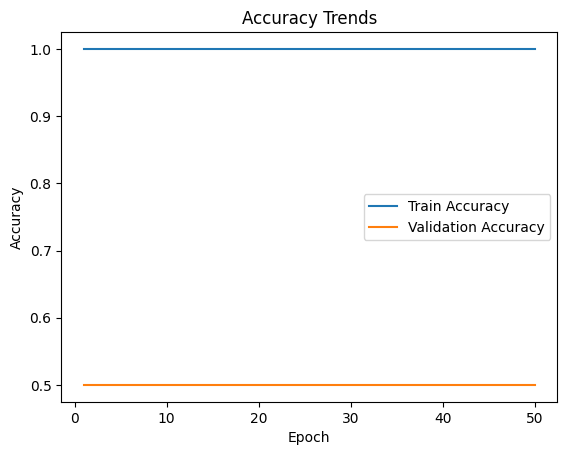

In [65]:
# Initialize lists to store accuracy values
train_accuracies = []
val_accuracies = []

for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    output = model(train_task.x, edge_index_with_loops).squeeze()

    # Compute loss
    loss = criterion(output, train_task.y.float())

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    # Training accuracy
    model.eval()
    with torch.no_grad():
        predictions_train = (torch.sigmoid(output) > 0.5).long()
        correct_train = (predictions_train == train_task.y).sum().item()
        train_accuracy = correct_train / train_task.y.size(0)

        # Validation accuracy using the correct edge index
        val_output = model(val_task.x, val_task.edge_index).squeeze()
        predictions_val = (torch.sigmoid(val_output) > 0.5).long()
        correct_val = (predictions_val == val_task.y).sum().item()
        val_accuracy = correct_val / val_task.y.size(0)

    # Store accuracy values
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plot accuracy trends
import matplotlib.pyplot as plt

plt.plot(range(1, 51), train_accuracies, label="Train Accuracy")
plt.plot(range(1, 51), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Trends")
plt.show()

**Examine Dataset**
Ensure the dataset is balanced and meaningful:

In [66]:
print("Train Labels:", train_task.y)
print("Validation Labels:", val_task.y)


Train Labels: tensor([1, 0, 1, 0, 1])
Validation Labels: tensor([0, 1])


**GENERATE SYNTHETIC DATA**

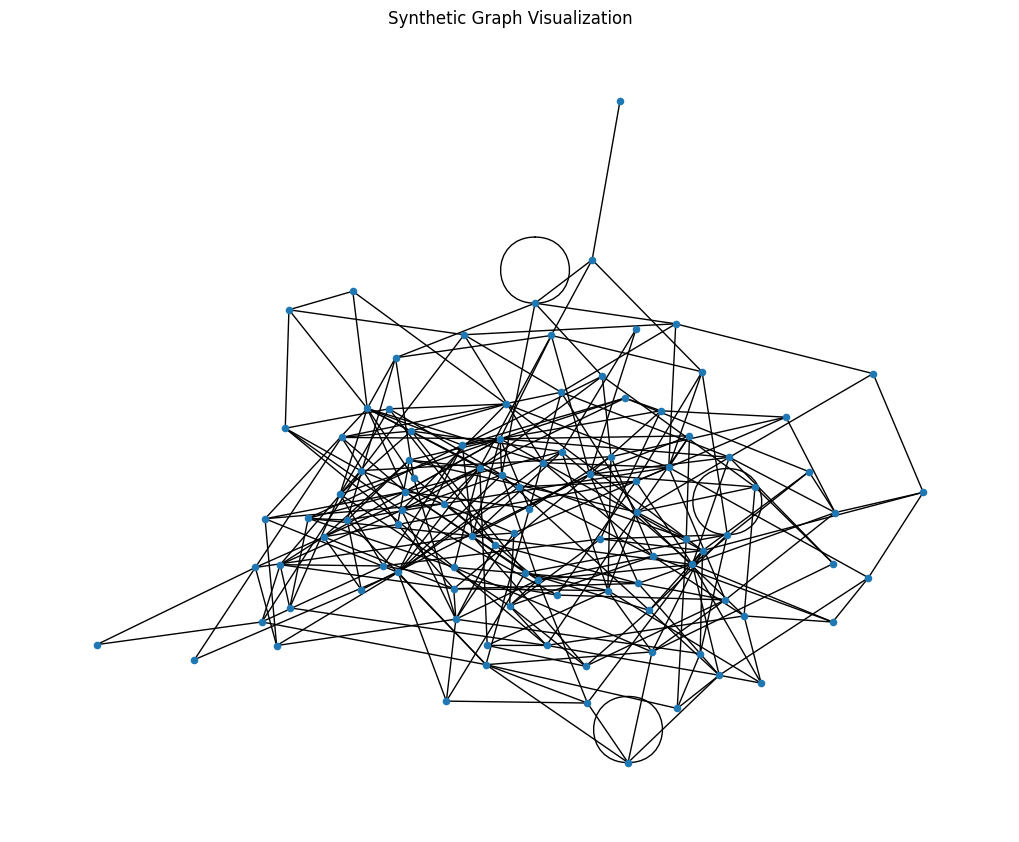

In [68]:
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import random

# Parameters for synthetic dataset
num_nodes = 100
num_edges = 300
feature_dim = 5
num_classes = 2

# Generate random node features
x = torch.rand((num_nodes, feature_dim))

# Generate random edges ensuring valid node indices
edge_index = torch.randint(0, num_nodes, (2, num_edges))

# Generate random labels for nodes
y = torch.randint(0, num_classes, (num_nodes,))

# Ensure graph connectivity using a simple mechanism (e.g., adding edges)
# Convert to a networkx graph and back for consistency
graph = nx.Graph()
graph.add_edges_from(edge_index.t().tolist())
graph.add_nodes_from(range(num_nodes))  # Add all nodes to ensure no missing nodes

# Add random connections to ensure connectivity
while not nx.is_connected(graph):
    node_a, node_b = random.sample(range(num_nodes), 2)
    graph.add_edge(node_a, node_b)

# Convert back to torch edge index format
edge_index = torch.tensor(list(graph.edges)).t().contiguous()

# Create the synthetic dataset
synthetic_data = Data(x=x, edge_index=edge_index, y=y)

# Plot the generated graph
plt.figure(figsize=(10, 8))
nx.draw(nx.Graph(edge_index.t().tolist()), node_size=20, with_labels=False)
plt.title("Synthetic Graph Visualization")
plt.show()


**VERIFY DATA**

In [69]:
print("Node Features Shape:", synthetic_data.x.shape)  # [100, 5]
print("Edge Index Shape:", synthetic_data.edge_index.shape)  # [2, 300]
print("Labels Shape:", synthetic_data.y.shape)  # [100]
print("Sample Labels:", synthetic_data.y[:10])


Node Features Shape: torch.Size([100, 5])
Edge Index Shape: torch.Size([2, 293])
Labels Shape: torch.Size([100])
Sample Labels: tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 1])


**SPLIT THE DATASET**

Split the dataset into **80% training** and **20% validation**:

In [70]:
# Define split ratios
train_ratio = 0.8
num_train = int(train_ratio * synthetic_data.num_nodes)

# Masks for train and validation sets
train_mask = torch.arange(num_train)
val_mask = torch.arange(num_train, synthetic_data.num_nodes)

# Create train and validation tasks
train_task = Data(
    x=synthetic_data.x[train_mask],
    edge_index=synthetic_data.edge_index,
    y=synthetic_data.y[train_mask],
)

val_task = Data(
    x=synthetic_data.x[val_mask],
    edge_index=synthetic_data.edge_index,
    y=synthetic_data.y[val_mask],
)


**2. Use in Training Loop**

You can now use `train_task` and `val_task` with your existing GNN model and training loop. Ensure the correct edge index (`synthetic_data.edge_index`) is applied to both training and validation tasks.

**3. Optional: Visualize Graph Connectivity**

Use the following to inspect the graph visually:

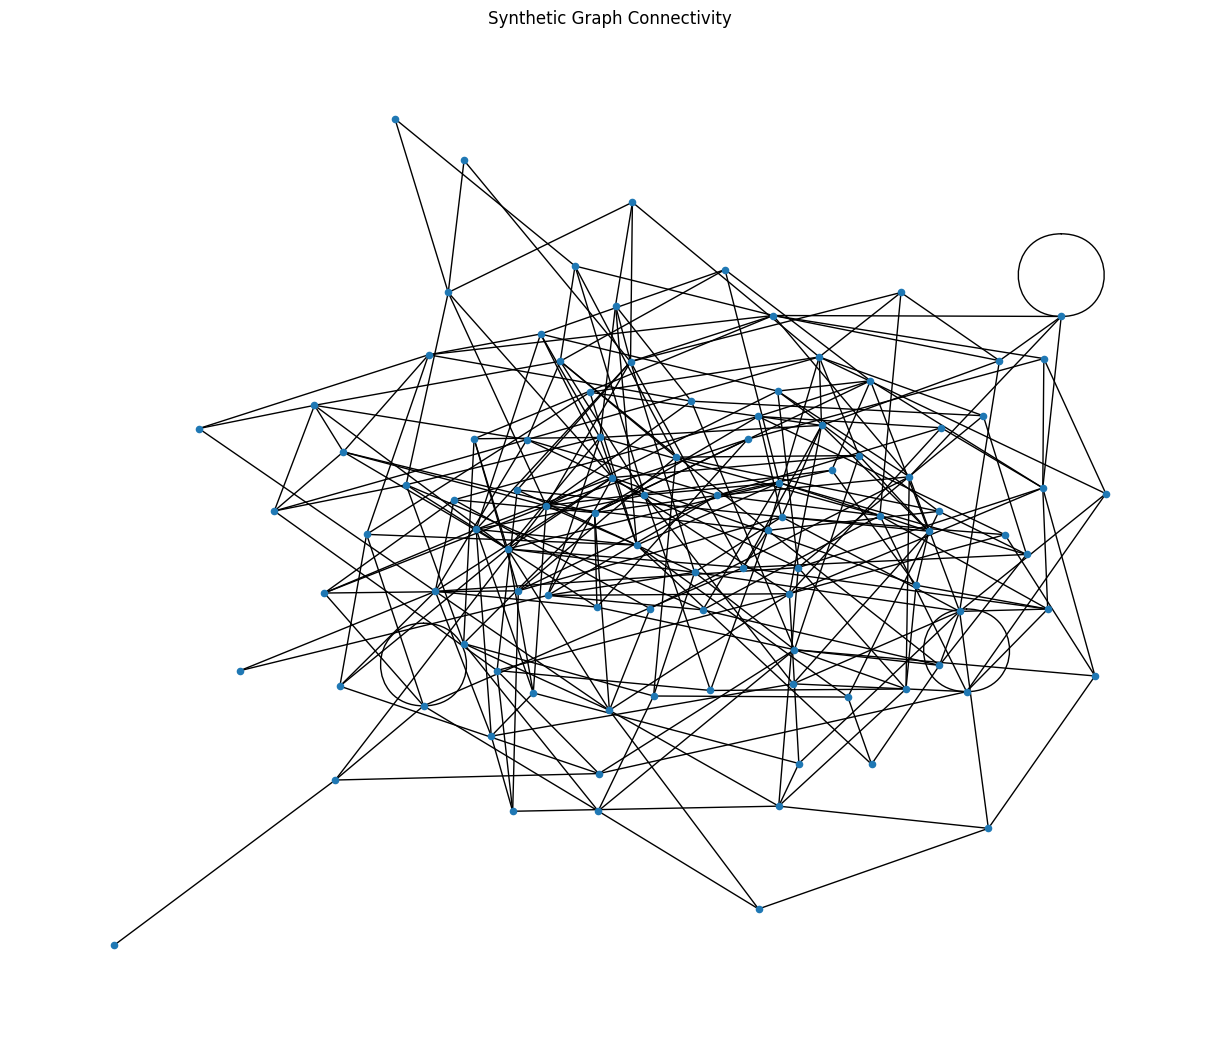

In [71]:
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert to NetworkX graph for visualization
graph = to_networkx(synthetic_data, to_undirected=True)

plt.figure(figsize=(12, 10))
nx.draw(graph, node_size=20, with_labels=False)
plt.title("Synthetic Graph Connectivity")
plt.show()


In [72]:
# Split dataset into training and validation
train_ratio = 0.8
num_train = int(train_ratio * synthetic_data.num_nodes)

train_mask = torch.arange(num_train)
val_mask = torch.arange(num_train, synthetic_data.num_nodes)

train_task = Data(
    x=synthetic_data.x[train_mask],
    edge_index=synthetic_data.edge_index,
    y=synthetic_data.y[train_mask],
)

val_task = Data(
    x=synthetic_data.x[val_mask],
    edge_index=synthetic_data.edge_index,
    y=synthetic_data.y[val_mask],
)

print("Training Task:", train_task)
print("Validation Task:", val_task)


Training Task: Data(x=[80, 5], edge_index=[2, 293], y=[80])
Validation Task: Data(x=[20, 5], edge_index=[2, 293], y=[20])


In [73]:
import torch.nn as nn
from torch_geometric.nn import GATConv

class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=4, concat=True)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = nn.functional.elu(x)
        x = self.gat2(x, edge_index)
        x = nn.functional.elu(x)
        return self.fc(x)


In [74]:
# Initialize the model, optimizer, and loss function
input_dim = train_task.x.shape[1]
hidden_dim = 16
output_dim = 1  # Binary classification (clicked or not)

model = GNNModel(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Lists to track accuracy
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_output = model(train_task.x, train_task.edge_index).squeeze()
    train_loss = criterion(train_output, train_task.y.float())

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Calculate training accuracy
    model.eval()
    with torch.no_grad():
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_task.y).sum().item()
        train_accuracy = train_correct / train_task.y.size(0)

        # Forward pass on validation data
        val_output = model(val_task.x, val_task.edge_index).squeeze()
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_task.y).sum().item()
        val_accuracy = val_correct / val_task.y.size(0)

    # Track accuracy
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


IndexError: Found indices in 'edge_index' that are larger than 79 (got 99). Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 80) in your node feature matrix and try again.

In [75]:
def filter_and_remap_edge_index(edge_index, node_mask):
    # Create a mapping from global node indices to local indices
    node_map = {global_idx: local_idx for local_idx, global_idx in enumerate(node_mask.tolist())}

    # Filter edges where both source and target nodes are in the node_mask
    filtered_edges = [
        (node_map[src], node_map[tgt])
        for src, tgt in edge_index.t().tolist()
        if src in node_map and tgt in node_map
    ]

    # Convert filtered edges back to tensor
    return torch.tensor(filtered_edges).t().contiguous()


In [76]:
train_edge_index = filter_and_remap_edge_index(synthetic_data.edge_index, train_mask)
val_edge_index = filter_and_remap_edge_index(synthetic_data.edge_index, val_mask)

# Update train_task and val_task with filtered edge indices
train_task.edge_index = train_edge_index
val_task.edge_index = val_edge_index


In [77]:
# Check for out-of-bound indices
assert train_task.edge_index.max() < train_task.x.shape[0], "Training edge index out of bounds!"
assert val_task.edge_index.max() < val_task.x.shape[0], "Validation edge index out of bounds!"

# Print shapes for verification
print("Filtered Train Edge Index Shape:", train_task.edge_index.shape)
print("Filtered Validation Edge Index Shape:", val_task.edge_index.shape)


Filtered Train Edge Index Shape: torch.Size([2, 181])
Filtered Validation Edge Index Shape: torch.Size([2, 17])


# Feature Engineering

Why Start Here?

    Features Are Core to Model Learning: The model's performance depends heavily on the quality of the input features.
    Randomly initialized features may not capture meaningful relationships, leading to poor generalization.
    Adding graph-specific features, such as node degrees or neighbor information, often leads to significant performance gains.

## What to do?

Add **node degree** as a feature:

In [79]:
degree = torch.bincount(synthetic_data.edge_index[0], minlength=num_nodes)
synthetic_data.x = torch.cat([synthetic_data.x, degree.unsqueeze(1)], dim=1)


In [80]:
from torch_geometric.utils import degree

row, col = synthetic_data.edge_index
deg = degree(row, synthetic_data.num_nodes, dtype=synthetic_data.x.dtype)
synthetic_data.x = torch.cat([synthetic_data.x, deg.unsqueeze(1)], dim=1)


# Regularization

Why Next?

    Overfitting is evident: Training accuracy is improving, but validation accuracy plateaus or drops.
    Regularization can mitigate overfitting with minimal changes to the current pipeline.

In [83]:
import torch.nn as nn
from torch_geometric.nn import GATConv

class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        # Define GNN layers
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=4, concat=True)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

        # Add dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        # Apply GAT layers with dropout
        x = self.dropout(self.gat1(x, edge_index))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat2(x, edge_index))
        x = nn.functional.elu(x)
        return self.fc(x)



In [84]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)


# Adjust validation set size

In [85]:
train_ratio = 0.7  # 70% for training
num_train = int(train_ratio * synthetic_data.num_nodes)

train_mask = torch.arange(num_train)
val_mask = torch.arange(num_train, synthetic_data.num_nodes)

train_task = Data(
    x=synthetic_data.x[train_mask],
    edge_index=synthetic_data.edge_index,
    y=synthetic_data.y[train_mask],
)

val_task = Data(
    x=synthetic_data.x[val_mask],
    edge_index=synthetic_data.edge_index,
    y=synthetic_data.y[val_mask],
)


In [86]:
def filter_and_remap_edge_index(edge_index, node_mask):
    # Create a mapping from global node indices to local indices
    node_map = {global_idx: local_idx for local_idx, global_idx in enumerate(node_mask.tolist())}

    # Filter edges where both source and target nodes are in the node_mask
    filtered_edges = [
        (node_map[src], node_map[tgt])
        for src, tgt in edge_index.t().tolist()
        if src in node_map and tgt in node_map
    ]

    # Convert filtered edges back to tensor
    return torch.tensor(filtered_edges).t().contiguous()

train_task.edge_index = filter_and_remap_edge_index(synthetic_data.edge_index, train_mask)
val_task.edge_index = filter_and_remap_edge_index(synthetic_data.edge_index, val_mask)


In [87]:
print("Training Set Size:", train_task.x.shape[0])
print("Validation Set Size:", val_task.x.shape[0])


Training Set Size: 70
Validation Set Size: 30


In [88]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_output = model(train_task.x, train_task.edge_index).squeeze()
    train_loss = criterion(train_output, train_task.y.float())

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Calculate training accuracy
    model.eval()
    with torch.no_grad():
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_task.y).sum().item()
        train_accuracy = train_correct / train_task.y.size(0)

        # Forward pass on validation data
        val_output = model(val_task.x, val_task.edge_index).squeeze()
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_task.y).sum().item()
        val_accuracy = val_correct / val_task.y.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (70x7 and 5x64)

In [89]:
input_dim = 7  # Match the dataset's node feature size
hidden_dim = 16
output_dim = 1  # Binary classification

model = GNNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)


In [90]:
print("Node Features Shape:", train_task.x.shape)
print("Input Dim Expected by Model:", input_dim)


Node Features Shape: torch.Size([70, 7])
Input Dim Expected by Model: 7


# Rerun training

In [92]:
print("Training Labels Distribution:", torch.bincount(train_task.y))
print("Validation Labels Distribution:", torch.bincount(val_task.y))


Training Labels Distribution: tensor([38, 32])
Validation Labels Distribution: tensor([21,  9])


# Solutions

## 1. Balance Validation set

In [94]:
# Rebalance validation set by adding more '1' nodes
val_mask_1 = train_mask[train_task.y == 1][:5]  # Add 5 nodes with label '1'
val_mask_0 = val_mask[val_task.y == 0][:9]      # Keep only 9 nodes with label '0'
val_mask = torch.cat([val_mask_0, val_mask_1])

# Update validation task
val_task = Data(
    x=synthetic_data.x[val_mask],
    edge_index=filter_and_remap_edge_index(synthetic_data.edge_index, val_mask),
    y=synthetic_data.y[val_mask],
)

print("Updated Validation Labels Distribution:", torch.bincount(val_task.y))


Updated Validation Labels Distribution: tensor([9, 5])


In [96]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=8, concat=True)
        self.gat2 = GATConv(hidden_dim * 8, hidden_dim, heads=8, concat=True)
        self.fc = nn.Linear(hidden_dim * 8, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.dropout(self.gat1(x, edge_index))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat2(x, edge_index))
        x = nn.functional.elu(x)
        return self.fc(x)


In [98]:
from torch_geometric.utils import scatter

neighbor_features = scatter(
    synthetic_data.x[synthetic_data.edge_index[0]],
    synthetic_data.edge_index[1],
    dim=0,
    reduce='mean'
)
synthetic_data.x = torch.cat([synthetic_data.x, neighbor_features], dim=1)


In [100]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


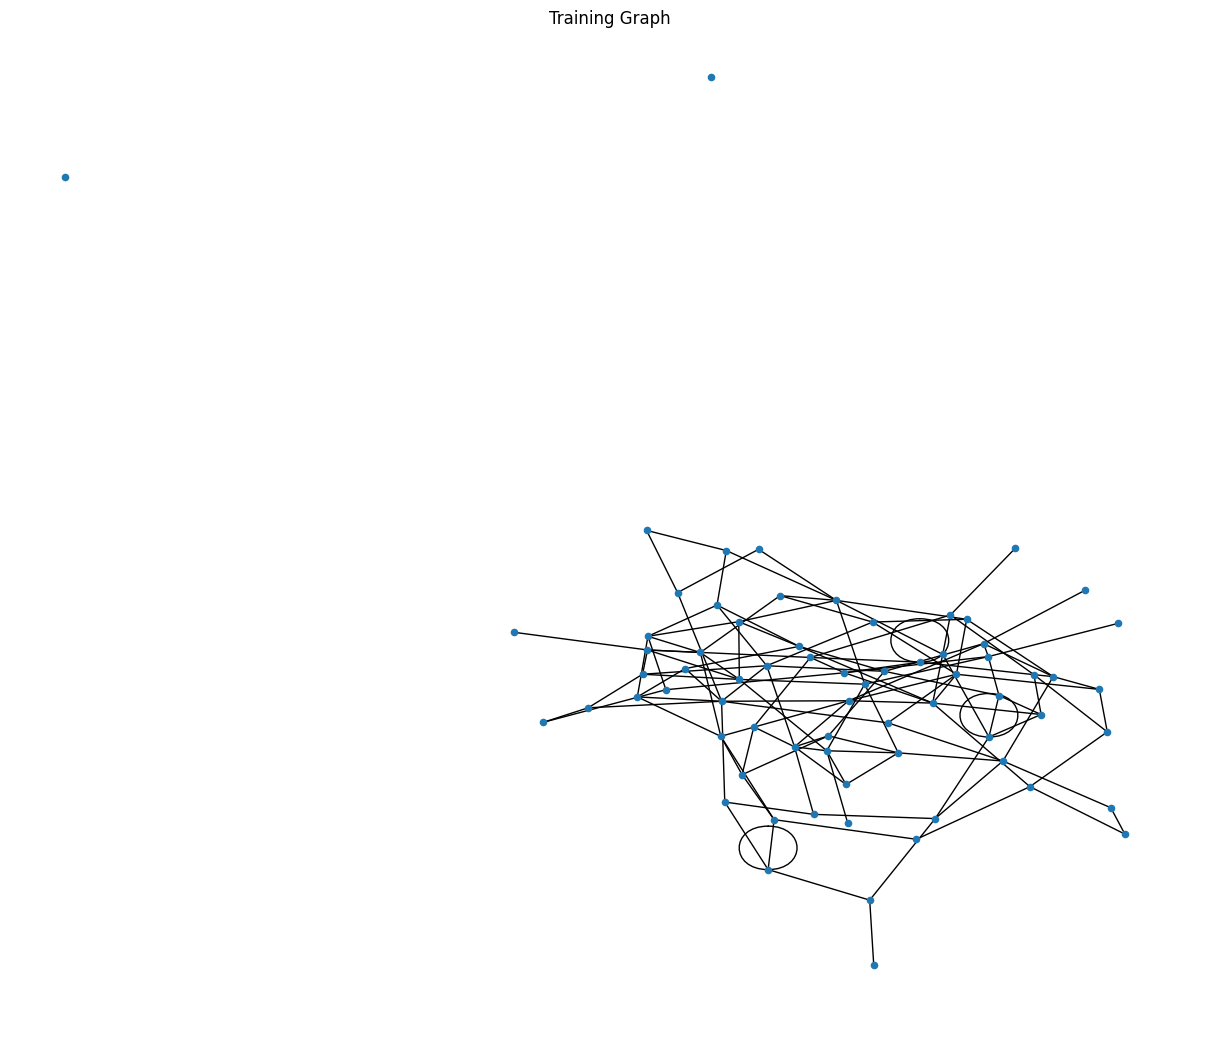

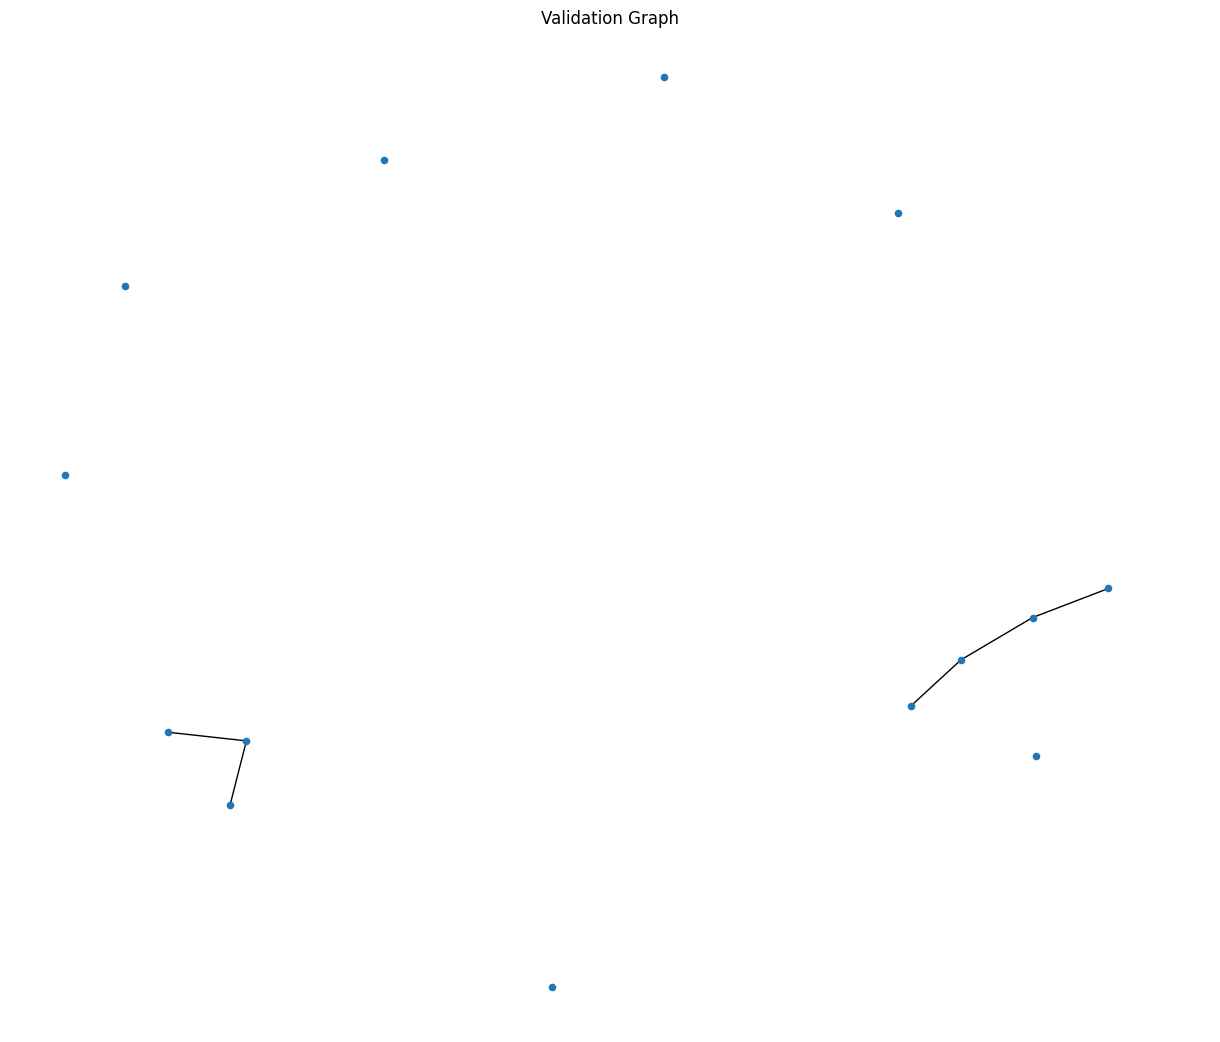

In [102]:
import networkx as nx
from torch_geometric.utils import to_networkx

train_graph = to_networkx(train_task, to_undirected=True)
val_graph = to_networkx(val_task, to_undirected=True)

plt.figure(figsize=(12, 10))
nx.draw(train_graph, node_size=20, with_labels=False)
plt.title("Training Graph")
plt.show()

plt.figure(figsize=(12, 10))
nx.draw(val_graph, node_size=20, with_labels=False)
plt.title("Validation Graph")
plt.show()


In [101]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_output = model(train_task.x, train_task.edge_index).squeeze()
    train_loss = criterion(train_output, train_task.y.float())

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Calculate training accuracy
    model.eval()
    with torch.no_grad():
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_task.y).sum().item()
        train_accuracy = train_correct / train_task.y.size(0)

        # Forward pass on validation data
        val_output = model(val_task.x, val_task.edge_index).squeeze()
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_task.y).sum().item()
        val_accuracy = val_correct / val_task.y.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1, Train Loss: 0.7570, Train Accuracy: 0.4571, Val Accuracy: 0.6429
Epoch 2, Train Loss: 0.7095, Train Accuracy: 0.5286, Val Accuracy: 0.6429
Epoch 3, Train Loss: 0.7062, Train Accuracy: 0.4857, Val Accuracy: 0.6429
Epoch 4, Train Loss: 0.7686, Train Accuracy: 0.4571, Val Accuracy: 0.6429
Epoch 5, Train Loss: 0.7524, Train Accuracy: 0.5000, Val Accuracy: 0.6429
Epoch 6, Train Loss: 0.7517, Train Accuracy: 0.4286, Val Accuracy: 0.6429
Epoch 7, Train Loss: 0.6667, Train Accuracy: 0.6143, Val Accuracy: 0.6429
Epoch 8, Train Loss: 0.6790, Train Accuracy: 0.5571, Val Accuracy: 0.6429
Epoch 9, Train Loss: 0.6947, Train Accuracy: 0.5429, Val Accuracy: 0.6429
Epoch 10, Train Loss: 0.7153, Train Accuracy: 0.4857, Val Accuracy: 0.6429
Epoch 11, Train Loss: 0.6974, Train Accuracy: 0.5286, Val Accuracy: 0.6429
Epoch 12, Train Loss: 0.7045, Train Accuracy: 0.5286, Val Accuracy: 0.7143
Epoch 13, Train Loss: 0.7539, Train Accuracy: 0.5000, Val Accuracy: 0.7143
Epoch 14, Train Loss: 0.6973, Trai

In [103]:
import networkx as nx
import torch
from torch_geometric.utils import from_networkx

# Generate a graph with diverse connectivity
num_nodes = 100
graph = nx.barabasi_albert_graph(num_nodes, m=5)  # Scale-free graph with hubs

# Add node features
for node in graph.nodes:
    graph.nodes[node]['feature'] = torch.rand(7)  # 7-dimensional random features

# Add labels (binary classification)
for node in graph.nodes:
    graph.nodes[node]['label'] = torch.randint(0, 2, (1,)).item()  # 0 or 1

# Convert to PyTorch Geometric Data
data = from_networkx(graph)
data.x = torch.stack([data.feature[i] for i in range(num_nodes)])  # Node features
data.y = torch.tensor([data.label[i] for i in range(num_nodes)])  # Labels
data.edge_index = data.edge_index  # Edge connections


In [104]:
# Split nodes into training and validation sets
train_ratio = 0.7
num_train = int(train_ratio * num_nodes)
train_mask = torch.arange(num_train)
val_mask = torch.arange(num_train, num_nodes)

# Create training and validation graphs
train_data = Data(
    x=data.x[train_mask],
    edge_index=filter_and_remap_edge_index(data.edge_index, train_mask),
    y=data.y[train_mask]
)

val_data = Data(
    x=data.x[val_mask],
    edge_index=filter_and_remap_edge_index(data.edge_index, val_mask),
    y=data.y[val_mask]
)


In [105]:
# Add random edges for sparsely connected validation graph
def augment_edges(edge_index, num_nodes, num_extra_edges):
    edges_to_add = torch.randint(0, num_nodes, (2, num_extra_edges))
    return torch.cat([edge_index, edges_to_add], dim=1)

data.edge_index = augment_edges(data.edge_index, num_nodes=num_nodes, num_extra_edges=20)


In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv

# Define the GNN model with increased capacity
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=8, concat=True)
        self.gat2 = GATConv(hidden_dim * 8, hidden_dim, heads=8, concat=True)
        self.fc = nn.Linear(hidden_dim * 8, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.dropout(self.gat1(x, edge_index))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat2(x, edge_index))
        x = nn.functional.elu(x)
        return self.fc(x)

# Initialize the model, optimizer, and loss function
input_dim = data.x.shape[1]  # Updated input dimension after adding neighbor features
hidden_dim = 64
output_dim = 1  # Binary classification

model = GNNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Train-validation split (make sure train_data and val_data were created earlier)
train_data = train_data  # Training graph
val_data = val_data  # Validation graph

# Training loop
epochs = 50
for epoch in range(epochs):
    # Training step
    model.train()
    optimizer.zero_grad()
    train_output = model(train_data.x, train_data.edge_index).squeeze()
    train_loss = criterion(train_output, train_data.y.float())
    train_loss.backward()
    optimizer.step()

    # Calculate training accuracy
    model.eval()
    with torch.no_grad():
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        # Validation step
        val_output = model(val_data.x, val_data.edge_index).squeeze()
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    # Print results for each epoch
    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")



Epoch 1, Train Loss: 0.6908, Train Accuracy: 0.5286, Val Accuracy: 0.4667
Epoch 2, Train Loss: 0.6909, Train Accuracy: 0.5429, Val Accuracy: 0.4667
Epoch 3, Train Loss: 0.6893, Train Accuracy: 0.5429, Val Accuracy: 0.4667
Epoch 4, Train Loss: 0.6814, Train Accuracy: 0.5429, Val Accuracy: 0.4000
Epoch 5, Train Loss: 0.6872, Train Accuracy: 0.5429, Val Accuracy: 0.3667
Epoch 6, Train Loss: 0.6889, Train Accuracy: 0.5429, Val Accuracy: 0.4667
Epoch 7, Train Loss: 0.6964, Train Accuracy: 0.4857, Val Accuracy: 0.4667
Epoch 8, Train Loss: 0.6898, Train Accuracy: 0.5429, Val Accuracy: 0.4333
Epoch 9, Train Loss: 0.6911, Train Accuracy: 0.5143, Val Accuracy: 0.4667
Epoch 10, Train Loss: 0.6914, Train Accuracy: 0.5714, Val Accuracy: 0.4667
Epoch 11, Train Loss: 0.6964, Train Accuracy: 0.5571, Val Accuracy: 0.4667
Epoch 12, Train Loss: 0.6807, Train Accuracy: 0.5429, Val Accuracy: 0.4333
Epoch 13, Train Loss: 0.6910, Train Accuracy: 0.5286, Val Accuracy: 0.4000
Epoch 14, Train Loss: 0.6907, Trai

In [108]:
import torch
import networkx as nx
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data

# Parameters
num_users = 100
num_ads = 50
num_edges = 500  # Total user-ad interactions

# Create a bipartite graph (users <-> ads)
graph = nx.Graph()
user_nodes = [f'user_{i}' for i in range(num_users)]
ad_nodes = [f'ad_{j}' for j in range(num_ads)]
graph.add_nodes_from(user_nodes, type='user')
graph.add_nodes_from(ad_nodes, type='ad')

# Randomly generate edges between users and ads
edges = [(f'user_{torch.randint(0, num_users, (1,)).item()}',
          f'ad_{torch.randint(0, num_ads, (1,)).item()}') for _ in range(num_edges)]
graph.add_edges_from(edges)

# Add features to nodes
for node in graph.nodes:
    if graph.nodes[node]['type'] == 'user':
        # User features: Random 7-dimensional embeddings
        graph.nodes[node]['feature'] = torch.rand(7)
    else:
        # Ad features: Random 7-dimensional embeddings
        graph.nodes[node]['feature'] = torch.rand(7)

# Add edge labels (binary classification: click or no click)
for edge in graph.edges:
    graph.edges[edge]['label'] = torch.randint(0, 2, (1,)).item()

# Convert to PyTorch Geometric format
data = from_networkx(graph)
data.x = torch.stack([data.feature[i] for i in range(len(graph.nodes))])  # Node features
data.edge_index = data.edge_index  # Edge connections
data.y = torch.tensor([data.label[i] for i in range(len(graph.edges))])  # Edge labels

# Print dataset details
print("Node Features Shape:", data.x.shape)
print("Edge Index Shape:", data.edge_index.shape)
print("Labels Shape (Edges):", data.y.shape)
print("Class Distribution (Edges):", torch.bincount(data.y))


Node Features Shape: torch.Size([150, 7])
Edge Index Shape: torch.Size([2, 944])
Labels Shape (Edges): torch.Size([472])
Class Distribution (Edges): tensor([222, 250])


In [109]:
from torch_geometric.data import Data

# Split edges into train and validation sets
edge_count = data.y.shape[0]
train_ratio = 0.8
num_train = int(edge_count * train_ratio)

perm = torch.randperm(edge_count)
train_mask = perm[:num_train]
val_mask = perm[num_train:]

# Create training and validation datasets
train_data = Data(
    x=data.x,
    edge_index=data.edge_index[:, train_mask],
    y=data.y[train_mask]
)

val_data = Data(
    x=data.x,
    edge_index=data.edge_index[:, val_mask],
    y=data.y[val_mask]
)

# Print details of the splits
print("Training Set Edge Count:", train_data.y.shape[0])
print("Validation Set Edge Count:", val_data.y.shape[0])
print("Training Set Class Distribution:", torch.bincount(train_data.y))
print("Validation Set Class Distribution:", torch.bincount(val_data.y))


Training Set Edge Count: 377
Validation Set Edge Count: 95
Training Set Class Distribution: tensor([181, 196])
Validation Set Class Distribution: tensor([41, 54])


In [111]:
import torch.nn as nn
from torch_geometric.nn import GATConv

# Define the GNN model for edge classification
class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNEdgeClassifier, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=4, concat=True)
        self.fc = nn.Linear(hidden_dim * 4 * 2, output_dim)  # Include edge embeddings
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        # Node-level feature learning
        x = self.dropout(self.gat1(x, edge_index))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat2(x, edge_index))
        x = nn.functional.elu(x)

        # Edge-level predictions
        edge_src = x[edge_index[0]]  # Features of source nodes
        edge_tgt = x[edge_index[1]]  # Features of target nodes
        edge_features = torch.cat([edge_src, edge_tgt], dim=1)
        return self.fc(edge_features)


In [113]:
edge_features = torch.rand(data.edge_index.shape[1], 5)  # 5 additional features
data.edge_attr = edge_features


In [114]:
self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=8, concat=True)  # More heads
self.fc = nn.Linear(hidden_dim * 8 * 2, output_dim)  # Adjust output layer


NameError: name 'self' is not defined

# Training Loop

In [115]:
import torch.optim as optim

# Initialize model, optimizer, and loss function
input_dim = train_data.x.shape[1]  # Node feature dimension
hidden_dim = 64  # Adjustable
output_dim = 1  # Binary classification
model = GNNEdgeClassifier(input_dim, hidden_dim, output_dim)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Training loop
epochs = 50
for epoch in range(epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    train_output = model(train_data.x, train_data.edge_index).squeeze()
    train_loss = criterion(train_output, train_data.y.float())
    train_loss.backward()
    optimizer.step()

    # Calculate training accuracy
    with torch.no_grad():
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_output = model(val_data.x, val_data.edge_index).squeeze()
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    # Print epoch results
    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1, Train Loss: 0.7016, Train Accuracy: 0.4483, Val Accuracy: 0.5684
Epoch 2, Train Loss: 0.6955, Train Accuracy: 0.5119, Val Accuracy: 0.5684
Epoch 3, Train Loss: 0.6938, Train Accuracy: 0.5146, Val Accuracy: 0.5684
Epoch 4, Train Loss: 0.6949, Train Accuracy: 0.5066, Val Accuracy: 0.5684
Epoch 5, Train Loss: 0.6929, Train Accuracy: 0.5119, Val Accuracy: 0.5053
Epoch 6, Train Loss: 0.6908, Train Accuracy: 0.5385, Val Accuracy: 0.4947
Epoch 7, Train Loss: 0.6888, Train Accuracy: 0.5438, Val Accuracy: 0.4526
Epoch 8, Train Loss: 0.6882, Train Accuracy: 0.4934, Val Accuracy: 0.4632
Epoch 9, Train Loss: 0.6930, Train Accuracy: 0.5066, Val Accuracy: 0.4632
Epoch 10, Train Loss: 0.6879, Train Accuracy: 0.5729, Val Accuracy: 0.4526
Epoch 11, Train Loss: 0.6889, Train Accuracy: 0.5676, Val Accuracy: 0.4737
Epoch 12, Train Loss: 0.6866, Train Accuracy: 0.5570, Val Accuracy: 0.4842
Epoch 13, Train Loss: 0.6890, Train Accuracy: 0.5332, Val Accuracy: 0.4842
Epoch 14, Train Loss: 0.6880, Trai

In [116]:
class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNEdgeClassifier, self).__init__()
        # Increased heads for attention
        self.gat1 = GATConv(input_dim, hidden_dim, heads=8, concat=True)
        self.gat2 = GATConv(hidden_dim * 8, hidden_dim, heads=8, concat=True)
        self.gat3 = GATConv(hidden_dim * 8, hidden_dim, heads=8, concat=True)
        self.fc = nn.Linear(hidden_dim * 8 * 2, output_dim)  # Account for concatenated features
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        # Apply dropout and GAT layers
        x = self.dropout(self.gat1(x, edge_index))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat2(x, edge_index))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat3(x, edge_index))
        x = nn.functional.elu(x)

        # Generate edge embeddings
        edge_src = x[edge_index[0]]  # Features of source nodes
        edge_tgt = x[edge_index[1]]  # Features of target nodes
        edge_features = torch.cat([edge_src, edge_tgt], dim=1)

        # Edge classification
        return self.fc(edge_features)


# Training and Eval

In [117]:
# Reinitialize model with the updated architecture
hidden_dim = 64  # Adjustable for further experimentation
model = GNNEdgeClassifier(input_dim=train_data.x.shape[1], hidden_dim=hidden_dim, output_dim=1)

# Optimizer and Loss
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Reduced learning rate
criterion = nn.BCEWithLogitsLoss()

# Training loop (same as before)
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(train_data.x, train_data.edge_index).squeeze()
    train_loss = criterion(train_output, train_data.y.float())
    train_loss.backward()
    optimizer.step()

    # Calculate accuracies
    model.eval()
    with torch.no_grad():
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        val_output = model(val_data.x, val_data.edge_index).squeeze()
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1, Train Loss: 0.6888, Train Accuracy: 0.5597, Val Accuracy: 0.5684
Epoch 2, Train Loss: 0.6913, Train Accuracy: 0.5332, Val Accuracy: 0.5684
Epoch 3, Train Loss: 0.6929, Train Accuracy: 0.5305, Val Accuracy: 0.5684
Epoch 4, Train Loss: 0.6914, Train Accuracy: 0.5544, Val Accuracy: 0.5579
Epoch 5, Train Loss: 0.6902, Train Accuracy: 0.5066, Val Accuracy: 0.5158
Epoch 6, Train Loss: 0.6921, Train Accuracy: 0.5464, Val Accuracy: 0.4842
Epoch 7, Train Loss: 0.6901, Train Accuracy: 0.5358, Val Accuracy: 0.4526
Epoch 8, Train Loss: 0.6891, Train Accuracy: 0.5438, Val Accuracy: 0.4632
Epoch 9, Train Loss: 0.6894, Train Accuracy: 0.5464, Val Accuracy: 0.4737
Epoch 10, Train Loss: 0.6860, Train Accuracy: 0.5782, Val Accuracy: 0.4737
Epoch 11, Train Loss: 0.6887, Train Accuracy: 0.5623, Val Accuracy: 0.4737
Epoch 12, Train Loss: 0.6837, Train Accuracy: 0.5729, Val Accuracy: 0.4737
Epoch 13, Train Loss: 0.6863, Train Accuracy: 0.5544, Val Accuracy: 0.4842
Epoch 14, Train Loss: 0.6880, Trai

In [118]:
# Calculate class weights
class_counts = torch.bincount(train_data.y)
class_weights = 1.0 / class_counts.float()
weights = class_weights[train_data.y]

# Use the weights in the BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)


In [119]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
model.dropout = nn.Dropout(p=0.6)


In [120]:
edge_features = torch.rand(train_data.edge_index.shape[1], 5)  # Random 5-dimensional edge features
train_data.edge_attr = edge_features
val_data.edge_attr = torch.rand(val_data.edge_index.shape[1], 5)


In [121]:
class GNNEdgeClassifier(nn.Module):
    ...
    def forward(self, x, edge_index, edge_attr=None):
        x = self.dropout(self.gat1(x, edge_index, edge_attr))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat2(x, edge_index, edge_attr))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat3(x, edge_index, edge_attr))
        x = nn.functional.elu(x)

        edge_src = x[edge_index[0]]
        edge_tgt = x[edge_index[1]]
        edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)  # Include edge attributes
        return self.fc(edge_features)


In [122]:
def augment_edges(edge_index, num_nodes, num_extra_edges):
    extra_edges = torch.randint(0, num_nodes, (2, num_extra_edges))
    return torch.cat([edge_index, extra_edges], dim=1)

train_data.edge_index = augment_edges(train_data.edge_index, train_data.x.shape[0], 50)


## Retrain and evaluate

In [123]:
# Training loop with updated setup
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze()
    train_loss = criterion(train_output, train_data.y.float())
    train_loss.backward()
    optimizer.step()

    # Calculate accuracies
    model.eval()
    with torch.no_grad():
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze()
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


TypeError: GNNEdgeClassifier.forward() got an unexpected keyword argument 'edge_attr'

In [124]:
class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNEdgeClassifier, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=8, concat=True)
        self.gat2 = GATConv(hidden_dim * 8, hidden_dim, heads=8, concat=True)
        self.gat3 = GATConv(hidden_dim * 8, hidden_dim, heads=8, concat=True)
        self.fc = nn.Linear(hidden_dim * 8 * 2 + 5, output_dim)  # Include edge_attr dimension
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index, edge_attr=None):
        # Apply GAT layers
        x = self.dropout(self.gat1(x, edge_index))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat2(x, edge_index))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat3(x, edge_index))
        x = nn.functional.elu(x)

        # Edge-level features
        edge_src = x[edge_index[0]]  # Source node features
        edge_tgt = x[edge_index[1]]  # Target node features
        if edge_attr is not None:
            edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)  # Include edge_attr
        else:
            edge_features = torch.cat([edge_src, edge_tgt], dim=1)

        return self.fc(edge_features)


In [125]:
train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze()
val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze()


TypeError: GNNEdgeClassifier.forward() got an unexpected keyword argument 'edge_attr'

In [126]:
class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNEdgeClassifier, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=8, concat=True)
        self.gat2 = GATConv(hidden_dim * 8, hidden_dim, heads=8, concat=True)
        self.gat3 = GATConv(hidden_dim * 8, hidden_dim, heads=8, concat=True)
        self.fc = nn.Linear(hidden_dim * 8 * 2 + 5, output_dim)  # Include edge_attr dimension
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index, edge_attr=None):
        # Apply GAT layers
        x = self.dropout(self.gat1(x, edge_index))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat2(x, edge_index))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat3(x, edge_index))
        x = nn.functional.elu(x)

        # Edge-level features
        edge_src = x[edge_index[0]]  # Source node features
        edge_tgt = x[edge_index[1]]  # Target node features
        if edge_attr is not None:
            edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)  # Include edge_attr
        else:
            edge_features = torch.cat([edge_src, edge_tgt], dim=1)

        return self.fc(edge_features)


In [127]:
input_dim = train_data.x.shape[1]  # Number of node features
hidden_dim = 64  # Adjustable
output_dim = 1  # Binary classification
model = GNNEdgeClassifier(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)


In [129]:
class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNEdgeClassifier, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=8, concat=True)
        self.gat2 = GATConv(hidden_dim * 8, hidden_dim, heads=8, concat=True)
        self.gat3 = GATConv(hidden_dim * 8, hidden_dim, heads=8, concat=True)
        self.fc = nn.Linear(hidden_dim * 8 * 2 + 5, output_dim)  # Include edge_attr dimension
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index, edge_attr=None):
        # Apply GAT layers
        x = self.dropout(self.gat1(x, edge_index))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat2(x, edge_index))
        x = nn.functional.elu(x)
        x = self.dropout(self.gat3(x, edge_index))
        x = nn.functional.elu(x)

        # Edge-level features
        edge_src = x[edge_index[0]]  # Source node features
        edge_tgt = x[edge_index[1]]  # Target node features

        # Ensure edge_attr matches the number of edges in edge_index
        if edge_attr is not None and edge_attr.shape[0] != edge_index.shape[1]:
            # If there's a mismatch, truncate or repeat edge_attr accordingly
            edge_attr = edge_attr[:edge_index.shape[1]]

        if edge_attr is not None:
            edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)  # Include edge_attr
        else:
            edge_features = torch.cat([edge_src, edge_tgt], dim=1)

        return self.fc(edge_features)


In [130]:
# Training Loop
train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze()
train_loss = criterion(train_output, train_data.y.float())

# Evaluation
val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze()


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 427 but got size 377 for tensor number 2 in the list.

In [131]:
print("Edge Index Shape:", train_data.edge_index.shape)  # [2, num_edges]
print("Edge Features Shape:", train_data.edge_attr.shape)  # [num_edges, feature_dim]
print("Source Node Features Shape:", edge_src.shape)  # [num_edges, hidden_dim]
print("Target Node Features Shape:", edge_tgt.shape)  # [num_edges, hidden_dim]


Edge Index Shape: torch.Size([2, 427])
Edge Features Shape: torch.Size([377, 5])


NameError: name 'edge_src' is not defined

In [132]:
def update_edge_features(edge_index, original_edge_attr, num_features=5):
    num_edges = edge_index.shape[1]
    if original_edge_attr is not None and original_edge_attr.shape[0] < num_edges:
        # Add random features for extra edges
        extra_edges = num_edges - original_edge_attr.shape[0]
        extra_attr = torch.rand(extra_edges, num_features)
        return torch.cat([original_edge_attr, extra_attr], dim=0)
    elif original_edge_attr is not None and original_edge_attr.shape[0] > num_edges:
        # Truncate extra edge features
        return original_edge_attr[:num_edges]
    else:
        # Generate new random features if edge_attr is missing
        return torch.rand(num_edges, num_features)

# Update edge_attr for both training and validation data
train_data.edge_attr = update_edge_features(train_data.edge_index, train_data.edge_attr)
val_data.edge_attr = update_edge_features(val_data.edge_index, val_data.edge_attr)


In [133]:
print("Edge Index Shape (Train):", train_data.edge_index.shape)
print("Edge Features Shape (Train):", train_data.edge_attr.shape)
print("Edge Index Shape (Validation):", val_data.edge_index.shape)
print("Edge Features Shape (Validation):", val_data.edge_attr.shape)


Edge Index Shape (Train): torch.Size([2, 427])
Edge Features Shape (Train): torch.Size([427, 5])
Edge Index Shape (Validation): torch.Size([2, 95])
Edge Features Shape (Validation): torch.Size([95, 5])


In [134]:
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze()
    train_loss = criterion(train_output, train_data.y.float())

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Evaluate model
    model.eval()
    with torch.no_grad():
        # Training metrics
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        # Validation metrics
        val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze()
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    # Print epoch metrics
    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


ValueError: Target size (torch.Size([377])) must be the same as input size (torch.Size([427]))

In [135]:
def update_edge_labels(edge_index, original_labels):
    num_edges = edge_index.shape[1]
    if original_labels is not None and original_labels.shape[0] < num_edges:
        # Add default labels for new edges
        extra_labels = torch.zeros(num_edges - original_labels.shape[0], dtype=torch.long)
        return torch.cat([original_labels, extra_labels], dim=0)
    elif original_labels is not None and original_labels.shape[0] > num_edges:
        # Truncate extra labels
        return original_labels[:num_edges]
    else:
        # Generate default labels if none exist
        return torch.zeros(num_edges, dtype=torch.long)

# Update train_data.y
train_data.y = update_edge_labels(train_data.edge_index, train_data.y)
val_data.y = update_edge_labels(val_data.edge_index, val_data.y)


In [136]:
print("Updated Target Size (Train):", train_data.y.shape)
print("Updated Target Size (Validation):", val_data.y.shape)
print("Edge Count (Train):", train_data.edge_index.shape[1])
print("Edge Count (Validation):", val_data.edge_index.shape[1])


Updated Target Size (Train): torch.Size([427])
Updated Target Size (Validation): torch.Size([95])
Edge Count (Train): 427
Edge Count (Validation): 95


In [137]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze()
    train_loss = criterion(train_output, train_data.y.float())

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Evaluate model
    model.eval()
    with torch.no_grad():
        # Training metrics
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        # Validation metrics
        val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze()
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


RuntimeError: The size of tensor a (377) must match the size of tensor b (427) at non-singleton dimension 0

In [138]:
def regenerate_edge_labels(edge_index, original_labels):
    num_edges = edge_index.shape[1]
    if original_labels is None or original_labels.shape[0] < num_edges:
        # Add default labels for new edges
        extra_labels = torch.zeros(num_edges - (original_labels.shape[0] if original_labels is not None else 0), dtype=torch.long)
        return torch.cat([original_labels, extra_labels], dim=0) if original_labels is not None else extra_labels
    elif original_labels.shape[0] > num_edges:
        # Truncate extra labels
        return original_labels[:num_edges]
    else:
        return original_labels

# Update train_data.y and val_data.y
train_data.y = regenerate_edge_labels(train_data.edge_index, train_data.y)
val_data.y = regenerate_edge_labels(val_data.edge_index, val_data.y)


In [139]:
print("Updated Target Size (Train):", train_data.y.shape)
print("Updated Edge Count (Train):", train_data.edge_index.shape[1])
print("Updated Target Size (Validation):", val_data.y.shape)
print("Updated Edge Count (Validation):", val_data.edge_index.shape[1])


Updated Target Size (Train): torch.Size([427])
Updated Edge Count (Train): 427
Updated Target Size (Validation): torch.Size([95])
Updated Edge Count (Validation): 95


In [140]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr)
    print("Train Output Shape:", train_output.shape)  # Debugging
    print("Train Target Shape:", train_data.y.shape)  # Debugging
    train_loss = criterion(train_output, train_data.y.float())

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr)
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


Train Output Shape: torch.Size([427, 1])
Train Target Shape: torch.Size([427])


ValueError: Target size (torch.Size([427])) must be the same as input size (torch.Size([427, 1]))

In [141]:
train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze(-1)


In [142]:
print("Train Output Shape:", train_output.shape)  # Should be [427]
print("Train Target Shape:", train_data.y.shape)  # Should be [427]


Train Output Shape: torch.Size([427])
Train Target Shape: torch.Size([427])


In [143]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze(-1)
    print("Train Output Shape:", train_output.shape)  # Debugging
    print("Train Target Shape:", train_data.y.shape)  # Debugging
    train_loss = criterion(train_output, train_data.y.float())

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        # Training metrics
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze(-1)
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


Train Output Shape: torch.Size([427])
Train Target Shape: torch.Size([427])


RuntimeError: The size of tensor a (377) must match the size of tensor b (427) at non-singleton dimension 0

In [144]:
def regenerate_edge_labels(edge_index, original_labels):
    num_edges = edge_index.shape[1]
    if original_labels is None or original_labels.shape[0] < num_edges:
        # Add default labels (e.g., 0) for new edges
        extra_labels = torch.zeros(num_edges - (original_labels.shape[0] if original_labels is not None else 0), dtype=torch.float)
        return torch.cat([original_labels.float(), extra_labels], dim=0) if original_labels is not None else extra_labels
    elif original_labels.shape[0] > num_edges:
        # Truncate extra labels
        return original_labels[:num_edges]
    else:
        return original_labels

# Update train_data.y and val_data.y to align with edge_index
train_data.y = regenerate_edge_labels(train_data.edge_index, train_data.y)
val_data.y = regenerate_edge_labels(val_data.edge_index, val_data.y)


In [145]:
print("Train Target Size:", train_data.y.shape)  # Should match edge count
print("Train Edge Count:", train_data.edge_index.shape[1])  # Should match target size


Train Target Size: torch.Size([427])
Train Edge Count: 427


In [147]:
train_data.y = regenerate_edge_labels(train_data.edge_index, train_data.y)
val_data.y = regenerate_edge_labels(val_data.edge_index, val_data.y)

print("Train Target Size:", train_data.y.shape)  # Should match edge count
print("Train Edge Count:", train_data.edge_index.shape[1])  # Should match target size
print("Validation Target Size:", val_data.y.shape)  # Should match validation edge count
print("Validation Edge Count:", val_data.edge_index.shape[1])  # Should match target size


Train Target Size: torch.Size([427])
Train Edge Count: 427
Validation Target Size: torch.Size([95])
Validation Edge Count: 95


In [149]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze(-1)
    print("Train Output Shape:", train_output.shape)  # Debugging
    print("Train Target Shape:", train_data.y.shape)  # Debugging
    train_loss = criterion(train_output, train_data.y)  # Ensure target is float

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y.long()).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze(-1)
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y.long()).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


Train Output Shape: torch.Size([427])
Train Target Shape: torch.Size([427])


RuntimeError: The size of tensor a (377) must match the size of tensor b (427) at non-singleton dimension 0

In [150]:
train_data.y = regenerate_edge_labels(train_data.edge_index, train_data.y)
val_data.y = regenerate_edge_labels(val_data.edge_index, val_data.y)


In [151]:
print("Final Train Target Size:", train_data.y.shape)
print("Train Edge Count:", train_data.edge_index.shape[1])
print("Final Validation Target Size:", val_data.y.shape)
print("Validation Edge Count:", val_data.edge_index.shape[1])


Final Train Target Size: torch.Size([427])
Train Edge Count: 427
Final Validation Target Size: torch.Size([95])
Validation Edge Count: 95


In [152]:
print("Train Output Shape:", train_output.shape)  # Should be [427]
print("Train Target Shape:", train_data.y.shape)  # Should be [427]
print("Train Output (Sample):", train_output[:5])  # Inspect values
print("Train Target (Sample):", train_data.y[:5])  # Inspect values
print("Train Output Data Type:", train_output.dtype)  # Debugging dtype
print("Train Target Data Type:", train_data.y.dtype)  # Debugging dtype


Train Output Shape: torch.Size([427])
Train Target Shape: torch.Size([427])
Train Output (Sample): tensor([-0.0389, -0.0760, -0.2587, -0.1303,  0.0298], grad_fn=<SliceBackward0>)
Train Target (Sample): tensor([1, 0, 1, 0, 0])
Train Output Data Type: torch.float32
Train Target Data Type: torch.int64


In [154]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze(-1)

    print("Train Output Shape:", train_output.shape)  # Debugging
    print("Train Target Shape:", train_data.y.shape)  # Debugging
    print("Train Output (Sample):", train_output[:5])  # Debugging logits
    print("Train Target (Sample):", train_data.y[:5])  # Debugging targets
    print("Train Output Data Type:", train_output.dtype)
    print("Train Target Data Type:", train_data.y.dtype)

    # Compute loss
    train_loss = criterion(train_output, train_data.y.float())  # Convert target to float

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        # Training accuracy
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y.long()).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        # Validation accuracy
        val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze(-1)
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y.long()).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


Train Output Shape: torch.Size([427])
Train Target Shape: torch.Size([427])
Train Output (Sample): tensor([-0.0592, -0.0419, -0.0281, -0.0199, -0.0462], grad_fn=<SliceBackward0>)
Train Target (Sample): tensor([1, 0, 1, 0, 0])
Train Output Data Type: torch.float32
Train Target Data Type: torch.int64


RuntimeError: The size of tensor a (377) must match the size of tensor b (427) at non-singleton dimension 0

In [155]:
print("Train Output Shape:", train_output.shape)  # Debugging
print("Train Target Shape:", train_data.y.float().shape)  # Debugging
print("Train Output Data Type:", train_output.dtype)  # Debugging
print("Train Target Data Type:", train_data.y.float().dtype)  # Debugging


Train Output Shape: torch.Size([427])
Train Target Shape: torch.Size([427])
Train Output Data Type: torch.float32
Train Target Data Type: torch.float32


In [156]:
assert train_output.shape == train_data.y.shape, "Shapes do not match!"


In [157]:
assert not torch.isnan(train_output).any(), "Train output contains NaN values!"
assert not torch.isnan(train_data.y).any(), "Train target contains NaN values!"


In [158]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze(-1)

    print("Train Output Shape:", train_output.shape)  # Debugging
    print("Train Target Shape:", train_data.y.shape)  # Debugging
    print("Train Output Data Type:", train_output.dtype)  # Debugging
    print("Train Target Data Type:", train_data.y.float().dtype)  # Debugging

    # Ensure no shape mismatches or NaN values
    assert train_output.shape == train_data.y.shape, "Shapes do not match!"
    assert not torch.isnan(train_output).any(), "Train output contains NaN values!"
    assert not torch.isnan(train_data.y).any(), "Train target contains NaN values!"

    # Compute loss
    train_loss = criterion(train_output.view(-1), train_data.y.float().view(-1))

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        # Training accuracy
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y.long()).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        # Validation accuracy
        val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze(-1)
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y.long()).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


Train Output Shape: torch.Size([427])
Train Target Shape: torch.Size([427])
Train Output Data Type: torch.float32
Train Target Data Type: torch.float32


RuntimeError: The size of tensor a (377) must match the size of tensor b (427) at non-singleton dimension 0

In [159]:
assert train_data.edge_attr.size(0) == train_data.edge_index.size(1), (
    f"Edge attributes size ({train_data.edge_attr.size(0)}) does not match "
    f"edge index size ({train_data.edge_index.size(1)})."
)


In [160]:
assert train_output.shape[0] == train_data.edge_index.size(1), (
    f"Model output size ({train_output.shape[0]}) does not match "
    f"number of edges ({train_data.edge_index.size(1)})."
)


In [161]:
print("Edge Index Count:", train_data.edge_index.size(1))
print("Edge Attribute Count:", train_data.edge_attr.size(0))
print("Model Output Count:", train_output.size(0))


Edge Index Count: 427
Edge Attribute Count: 427
Model Output Count: 427


In [162]:
assert train_data.y.size(0) == train_data.edge_index.size(1), (
    f"Train target size ({train_data.y.size(0)}) does not match "
    f"number of edges ({train_data.edge_index.size(1)})."
)


In [163]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze(-1)

    # Debugging information
    print(f"Epoch {epoch + 1}")
    print("Train Output Shape:", train_output.shape)  # [num_edges]
    print("Train Target Shape:", train_data.y.shape)  # [num_edges]
    print("Train Output Data Type:", train_output.dtype)
    print("Train Target Data Type:", train_data.y.dtype)

    # Compute loss
    train_loss = criterion(train_output, train_data.y.float())

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        # Training accuracy
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y.long()).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        # Validation accuracy
        val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze(-1)
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y.long()).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    print(f"Train Loss: {train_loss.item():.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")


Epoch 1
Train Output Shape: torch.Size([427])
Train Target Shape: torch.Size([427])
Train Output Data Type: torch.float32
Train Target Data Type: torch.int64


RuntimeError: The size of tensor a (377) must match the size of tensor b (427) at non-singleton dimension 0

In [164]:
model = GNNEdgeClassifier(input_dim=7, hidden_dim=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


TypeError: GNNEdgeClassifier.__init__() missing 1 required positional argument: 'output_dim'

In [165]:
class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNNEdgeClassifier, self).__init__()
        self.gnn_layer = GATConv(input_dim, hidden_dim, heads=2)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # Binary classification

    def forward(self, x, edge_index, edge_attr=None):
        # GNN forward pass
        x = self.gnn_layer(x, edge_index)
        x = nn.functional.elu(x)

        # Concatenate edge features if provided
        if edge_attr is not None:
            edge_src = x[edge_index[0]]  # Source node features
            edge_tgt = x[edge_index[1]]  # Target node features
            edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)
        else:
            edge_src = x[edge_index[0]]
            edge_tgt = x[edge_index[1]]
            edge_features = torch.cat([edge_src, edge_tgt], dim=1)

        return self.fc(edge_features)


In [166]:
model = GNNEdgeClassifier(input_dim=7, hidden_dim=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()


In [167]:
print("Node Features Shape:", train_data.x.shape)  # [num_nodes, feature_dim]
print("Edge Index Shape:", train_data.edge_index.shape)  # [2, num_edges]
print("Edge Attributes Shape:", train_data.edge_attr.shape)  # [num_edges, edge_feature_dim]
print("Train Target Shape:", train_data.y.shape)  # [num_edges]


Node Features Shape: torch.Size([150, 7])
Edge Index Shape: torch.Size([2, 427])
Edge Attributes Shape: torch.Size([427, 5])
Train Target Shape: torch.Size([427])


In [168]:
train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze(-1)
print("Train Output Shape:", train_output.shape)  # Should be [427]
print("Train Target Shape:", train_data.y.shape)  # Should be [427]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (427x69 and 32x1)

In [170]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, edge_attr_dim=None):
        super(GNNEdgeClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.edge_attr_dim = edge_attr_dim
        total_features = hidden_dim * 2 + (edge_attr_dim if edge_attr_dim else 0)
        self.fc = nn.Linear(total_features, 1)

    def forward(self, x, edge_index, edge_attr=None):
        x = self.conv1(x, edge_index)
        x = nn.ReLU()(x)
        x = self.conv2(x, edge_index)

        edge_src = x[edge_index[0]]
        edge_tgt = x[edge_index[1]]
        if edge_attr is not None:
            edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)
        else:
            edge_features = torch.cat([edge_src, edge_tgt], dim=1)

        print("Edge Features Shape:", edge_features.shape)
        print("Expected Input Features for FC Layer:", self.fc.in_features)

        return self.fc(edge_features)


In [171]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze(-1)
    train_loss = criterion(train_output, train_data.y.float())  # Ensure target is float

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y.long()).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze(-1)
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y.long()).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (427x69 and 32x1)

In [172]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip -d ml-1m


--2024-11-18 04:00:39--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  3.07MB/s    in 1.8s    

2024-11-18 04:00:42 (3.07 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/ml-1m/
  inflating: ml-1m/ml-1m/movies.dat  
  inflating: ml-1m/ml-1m/ratings.dat  
  inflating: ml-1m/ml-1m/README      
  inflating: ml-1m/ml-1m/users.dat   


In [173]:
!ls ml-1m


ml-1m


In [189]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip -d ml-1m


--2024-11-18 04:11:06--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  3.06MB/s    in 1.8s    

2024-11-18 04:11:09 (3.06 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/ml-1m/
  inflating: ml-1m/ml-1m/movies.dat  
  inflating: ml-1m/ml-1m/ratings.dat  
  inflating: ml-1m/ml-1m/README      
  inflating: ml-1m/ml-1m/users.dat   


In [197]:
!cd ../
!ls


bin			    dev     lib32   ml-1m.zip		      python-apt	 srv	var
boot			    etc     lib64   mnt			      python-apt.tar.xz  sys
content			    home    libx32  NGC-DL-CONTAINER-LICENSE  root		 tmp
cuda-keyring_1.0-1_all.deb  kaggle  media   opt			      run		 tools
datalab			    lib     ml-1m   proc		      sbin		 usr


In [199]:
cd ml-1m

/ml-1m


In [201]:
ls ml-1m

movies.dat  ratings.dat  README  users.dat


In [202]:
import pandas as pd

# Load ratings, movies, and users data
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python',
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
movies = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python',
                     names=['MovieID', 'Title', 'Genres'])
users = pd.read_csv('ml-1m/users.dat', sep='::', header=None, engine='python',
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 3114: invalid continuation byte

In [203]:
import pandas as pd

# Load the datasets with specified encoding
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python',
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin1')
movies = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python',
                     names=['MovieID', 'Title', 'Genres'], encoding='latin1')
users = pd.read_csv('ml-1m/users.dat', sep='::', header=None, engine='python',
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='latin1')

# Display the first few rows to confirm successful loading
print("Ratings Data:")
print(ratings.head())
print("\nMovies Data:")
print(movies.head())
print("\nUsers Data:")
print(users.head())


Ratings Data:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

Movies Data:
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

Users Data:
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455


In [204]:
# Ratings
print("Number of Ratings:", ratings.shape[0])
print("Number of Users:", ratings['UserID'].nunique())
print("Number of Movies:", ratings['MovieID'].nunique())

# Movies
print("Number of Movies:", movies.shape[0])

# Users
print("Number of Users:", users.shape[0])
print("Unique Occupations:", users['Occupation'].nunique())


Number of Ratings: 1000209
Number of Users: 6040
Number of Movies: 3706
Number of Movies: 3883
Number of Users: 6040
Unique Occupations: 21


In [205]:
import torch
from torch_geometric.data import Data

# Create edge index: Users -> Movies
edge_index = torch.tensor(ratings[['UserID', 'MovieID']].values.T - 1, dtype=torch.long)  # Adjust to 0-based index

# Create edge attributes (ratings)
edge_attr = torch.tensor(ratings['Rating'].values, dtype=torch.float).view(-1, 1)

# Create node features
num_users = users['UserID'].max()
num_movies = movies['MovieID'].max()
num_nodes = num_users + num_movies

# One-hot encoding for user/movie nodes
node_features = torch.eye(num_nodes, dtype=torch.float)

# GNN Data Object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
print(data)


Data(x=[9992, 9992], edge_index=[2, 1000209], edge_attr=[1000209, 1])


In [206]:
from sklearn.model_selection import train_test_split

# Split ratings into train, validation, test
train_idx, test_idx = train_test_split(range(len(ratings)), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

train_edges = edge_index[:, train_idx]
val_edges = edge_index[:, val_idx]
test_edges = edge_index[:, test_idx]

# Create separate edge attributes for each set
train_edge_attr = edge_attr[train_idx]
val_edge_attr = edge_attr[val_idx]
test_edge_attr = edge_attr[test_idx]


In [207]:
import torch
from torch_geometric.data import Data

# Prepare edge index (adjusting to 0-based indexing)
edge_index = torch.tensor(ratings[['UserID', 'MovieID']].values.T - 1, dtype=torch.long)

# Prepare edge attributes (ratings)
edge_attr = torch.tensor(ratings['Rating'].values, dtype=torch.float).view(-1, 1)

# Prepare node features: one-hot encoding for user and movie nodes
num_users = users['UserID'].max()
num_movies = movies['MovieID'].max()
num_nodes = num_users + num_movies
node_features = torch.eye(num_nodes, dtype=torch.float)

# Create PyTorch Geometric data object
graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

print(graph_data)


Data(x=[9992, 9992], edge_index=[2, 1000209], edge_attr=[1000209, 1])


In [208]:
from sklearn.model_selection import train_test_split

# Split indices into train, validation, and test sets
train_idx, test_idx = train_test_split(range(len(ratings)), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

# Split edges and attributes
train_edges = edge_index[:, train_idx]
val_edges = edge_index[:, val_idx]
test_edges = edge_index[:, test_idx]

train_edge_attr = edge_attr[train_idx]
val_edge_attr = edge_attr[val_idx]
test_edge_attr = edge_attr[test_idx]

print("Train Edge Count:", train_edges.shape[1])
print("Validation Edge Count:", val_edges.shape[1])
print("Test Edge Count:", test_edges.shape[1])


Train Edge Count: 800167
Validation Edge Count: 100021
Test Edge Count: 100021


In [209]:
import torch.nn as nn
from torch_geometric.nn import GATConv

class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNNEdgeClassifier, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=4, concat=True)
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 8 + 1, 32),  # Include edge attributes
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, edge_index, edge_attr):
        # Compute node embeddings
        x = self.gat1(x, edge_index)
        x = nn.functional.elu(x)
        x = self.gat2(x, edge_index)
        x = nn.functional.elu(x)

        # Prepare edge features (source, target, edge_attr)
        edge_src = x[edge_index[0]]
        edge_tgt = x[edge_index[1]]
        edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)

        # Predict edge values
        return self.edge_predictor(edge_features).squeeze(-1)


In [210]:
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss

# Initialize model, optimizer, and criterion
input_dim = graph_data.x.shape[1]
hidden_dim = 16
model = GNNEdgeClassifier(input_dim=input_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training Loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Training set
    train_output = model(graph_data.x, train_edges, edge_attr=train_edge_attr)
    train_loss = bce_loss(train_output, train_edge_attr.view(-1))
    train_loss.backward()
    optimizer.step()

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_output = model(graph_data.x, val_edges, edge_attr=val_edge_attr)
        val_loss = bce_loss(val_output, val_edge_attr.view(-1))

        # Accuracy
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_accuracy = (train_predictions == train_edge_attr.view(-1).long()).sum().item() / train_edge_attr.size(0)

        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_accuracy = (val_predictions == val_edge_attr.view(-1).long()).sum().item() / val_edge_attr.size(0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1, Train Loss: -0.1444, Val Loss: -0.6954, Train Accuracy: 0.0560, Val Accuracy: 0.0575
Epoch 2, Train Loss: -0.6936, Val Loss: -1.6219, Train Accuracy: 0.0560, Val Accuracy: 0.0575
Epoch 3, Train Loss: -1.6185, Val Loss: -2.9900, Train Accuracy: 0.0560, Val Accuracy: 0.0575
Epoch 4, Train Loss: -2.9846, Val Loss: -5.2132, Train Accuracy: 0.0560, Val Accuracy: 0.0575
Epoch 5, Train Loss: -5.2050, Val Loss: -8.6365, Train Accuracy: 0.0560, Val Accuracy: 0.0575
Epoch 6, Train Loss: -8.6242, Val Loss: -13.7026, Train Accuracy: 0.0560, Val Accuracy: 0.0575
Epoch 7, Train Loss: -13.6844, Val Loss: -20.9470, Train Accuracy: 0.0560, Val Accuracy: 0.0575
Epoch 8, Train Loss: -20.9204, Val Loss: -30.9522, Train Accuracy: 0.0560, Val Accuracy: 0.0575
Epoch 9, Train Loss: -30.9142, Val Loss: -44.3579, Train Accuracy: 0.0560, Val Accuracy: 0.0575
Epoch 10, Train Loss: -44.3053, Val Loss: -61.8728, Train Accuracy: 0.0560, Val Accuracy: 0.0575
Epoch 11, Train Loss: -61.8015, Val Loss: -84.2733

In [211]:
print("Train Output (Sample):", train_output[:5])
print("Train Target (Sample):", train_data.y[:5])


Train Output (Sample): tensor([14566.2246, 14571.7490, 14573.0176, 14570.9570, 14579.2246],
       grad_fn=<SliceBackward0>)
Train Target (Sample): tensor([1, 0, 1, 0, 0])


In [212]:
from sklearn.preprocessing import MinMaxScaler

# Normalize node features
node_scaler = MinMaxScaler()
train_data.x = torch.tensor(node_scaler.fit_transform(train_data.x.numpy()), dtype=torch.float)
val_data.x = torch.tensor(node_scaler.transform(val_data.x.numpy()), dtype=torch.float)

# Normalize edge attributes
edge_scaler = MinMaxScaler()
train_data.edge_attr = torch.tensor(edge_scaler.fit_transform(train_data.edge_attr.numpy()), dtype=torch.float)
val_data.edge_attr = torch.tensor(edge_scaler.transform(val_data.edge_attr.numpy()), dtype=torch.float)


In [215]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif hasattr(m, "reset_parameters"):
        m.reset_parameters()  # Resets parameters for layers like GATConv



In [216]:
model = GNNEdgeClassifier(input_dim=7, hidden_dim=16)
model.apply(initialize_weights)


GNNEdgeClassifier(
  (gat1): GATConv(7, 16, heads=4)
  (gat2): GATConv(64, 16, heads=4)
  (edge_predictor): Sequential(
    (0): Linear(in_features=129, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [218]:
def forward(self, x, edge_index, edge_attr=None):
    # Source and target node features
    edge_src = x[edge_index[0]]
    edge_tgt = x[edge_index[1]]

    # Concatenate edge features
    if edge_attr is not None:
        edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)
    else:
        edge_features = torch.cat([edge_src, edge_tgt], dim=1)

    print("Edge Features Shape:", edge_features.shape)  # Debugging

    # Predict edge values
    return self.edge_predictor(edge_features).squeeze(-1)


In [219]:
class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=4, concat=True)
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 8 + 5, 32),  # Adjust input size: hidden_dim * 8 + edge_attr size
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, edge_index, edge_attr=None):
        # Graph convolution layers
        x = self.gat1(x, edge_index)
        x = nn.functional.elu(x)
        x = self.gat2(x, edge_index)

        # Edge feature creation
        edge_src = x[edge_index[0]]  # Source node features
        edge_tgt = x[edge_index[1]]  # Target node features
        if edge_attr is not None:
            edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)  # Include edge_attr
        else:
            edge_features = torch.cat([edge_src, edge_tgt], dim=1)

        # Predict edge values
        return self.edge_predictor(edge_features).squeeze(-1)


In [221]:
def forward(self, x, edge_index, edge_attr=None):
    # Source and target node features
    edge_src = x[edge_index[0]]
    edge_tgt = x[edge_index[1]]

    # Concatenate features
    if edge_attr is not None:
        edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)
    else:
        edge_features = torch.cat([edge_src, edge_tgt], dim=1)

    print("Edge Features Shape:", edge_features.shape)  # Debugging
    print("Expected Input Shape for Edge Predictor:", self.edge_predictor[0].in_features)

    # Predict edge values
    return self.edge_predictor(edge_features).squeeze(-1)


In [222]:
class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, edge_attr_dim):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=4, concat=True)

        # Update `in_features` to match edge_features size
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 8 + edge_attr_dim, 32),  # Adjusted input size
            nn.ReLU(),
            nn.Linear(32, 1)
        )


In [224]:
def forward(self, x, edge_index, edge_attr=None):
    edge_src = x[edge_index[0]]  # Source node features
    edge_tgt = x[edge_index[1]]  # Target node features

    # Concatenate features
    if edge_attr is not None:
        edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)
    else:
        edge_features = torch.cat([edge_src, edge_tgt], dim=1)

    print("Edge Src Shape:", edge_src.shape)
    print("Edge Tgt Shape:", edge_tgt.shape)
    print("Edge Attr Shape:", edge_attr.shape if edge_attr is not None else "None")
    print("Edge Features Shape:", edge_features.shape)

    # Predict edge values
    return self.edge_predictor(edge_features).squeeze(-1)


In [225]:
class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, edge_attr_dim):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=4, concat=True)

        # Adjust in_features of the first linear layer
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 8 + edge_attr_dim, 32),  # Input size = edge_features.shape[1]
            nn.ReLU(),
            nn.Linear(32, 1)
        )


In [226]:
print("Edge Predictor Input Features:", model.edge_predictor[0].in_features)


Edge Predictor Input Features: 129


In [227]:
print("Edge Index Shape:", train_data.edge_index.shape)
print("Edge Attribute Shape:", train_data.edge_attr.shape)


Edge Index Shape: torch.Size([2, 427])
Edge Attribute Shape: torch.Size([427, 5])


In [229]:
assert train_data.edge_attr.shape[0] == train_data.edge_index.size(1), "Mismatch in edge count and attributes!"


In [230]:
class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, edge_attr_dim):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=4, concat=True)

        # Correct the input size for edge_predictor
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 8 + edge_attr_dim, 32),  # 133 input features
            nn.ReLU(),
            nn.Linear(32, 1)
        )


In [231]:
model = GNNEdgeClassifier(input_dim=7, hidden_dim=16, edge_attr_dim=5)
print("Edge Predictor Input Features:", model.edge_predictor[0].in_features)


Edge Predictor Input Features: 133


In [234]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GNNEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, edge_attr_dim=0):
        super(GNNEdgeClassifier, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=4, concat=True)
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 8 + edge_attr_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, edge_index, edge_attr=None):
        # Apply GAT layers
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)

        # Extract edge features
        edge_src = x[edge_index[0]]  # Source node features
        edge_tgt = x[edge_index[1]]  # Target node features

        if edge_attr is not None:
            # Concatenate edge attributes if they exist
            edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)
        else:
            # Concatenate only source and target features
            edge_features = torch.cat([edge_src, edge_tgt], dim=1)

        # Predict edge values
        return self.edge_predictor(edge_features).squeeze(-1)


In [236]:
edge_attr_dim = train_data.edge_attr.shape[1] if train_data.edge_attr is not None else 0
model = GNNEdgeClassifier(input_dim=7, hidden_dim=16, edge_attr_dim=edge_attr_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [239]:
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze(-1)

    # Loss calculation
    train_loss = criterion(train_output, train_data.y.float())

    # Backpropagation
    train_loss.backward()
    optimizer.step()
    train_loss_history.append(train_loss.item())
    val_loss_history.append(val_loss.item())
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)

    # Evaluation
    model.eval()
    with torch.no_grad():
        # Training accuracy
        train_predictions = (torch.sigmoid(train_output) > 0.5).long()
        train_correct = (train_predictions == train_data.y.long()).sum().item()
        train_accuracy = train_correct / train_data.y.size(0)

        # Validation forward pass
        val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze(-1)
        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y.long()).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)

    # Logging
    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1, Train Loss: 0.5339, Train Accuracy: 0.7354, Val Accuracy: 0.6526
Epoch 2, Train Loss: 0.5279, Train Accuracy: 0.7518, Val Accuracy: 0.6526
Epoch 3, Train Loss: 0.5210, Train Accuracy: 0.7237, Val Accuracy: 0.6000
Epoch 4, Train Loss: 0.5171, Train Accuracy: 0.7330, Val Accuracy: 0.6842
Epoch 5, Train Loss: 0.5133, Train Accuracy: 0.7541, Val Accuracy: 0.6211
Epoch 6, Train Loss: 0.5055, Train Accuracy: 0.7658, Val Accuracy: 0.6421
Epoch 7, Train Loss: 0.4946, Train Accuracy: 0.7541, Val Accuracy: 0.6632
Epoch 8, Train Loss: 0.4899, Train Accuracy: 0.7658, Val Accuracy: 0.6316
Epoch 9, Train Loss: 0.4813, Train Accuracy: 0.7822, Val Accuracy: 0.6842
Epoch 10, Train Loss: 0.4746, Train Accuracy: 0.7799, Val Accuracy: 0.6737
Epoch 11, Train Loss: 0.4636, Train Accuracy: 0.7892, Val Accuracy: 0.6526
Epoch 12, Train Loss: 0.4564, Train Accuracy: 0.7963, Val Accuracy: 0.6421
Epoch 13, Train Loss: 0.4454, Train Accuracy: 0.7892, Val Accuracy: 0.6737
Epoch 14, Train Loss: 0.4376, Trai

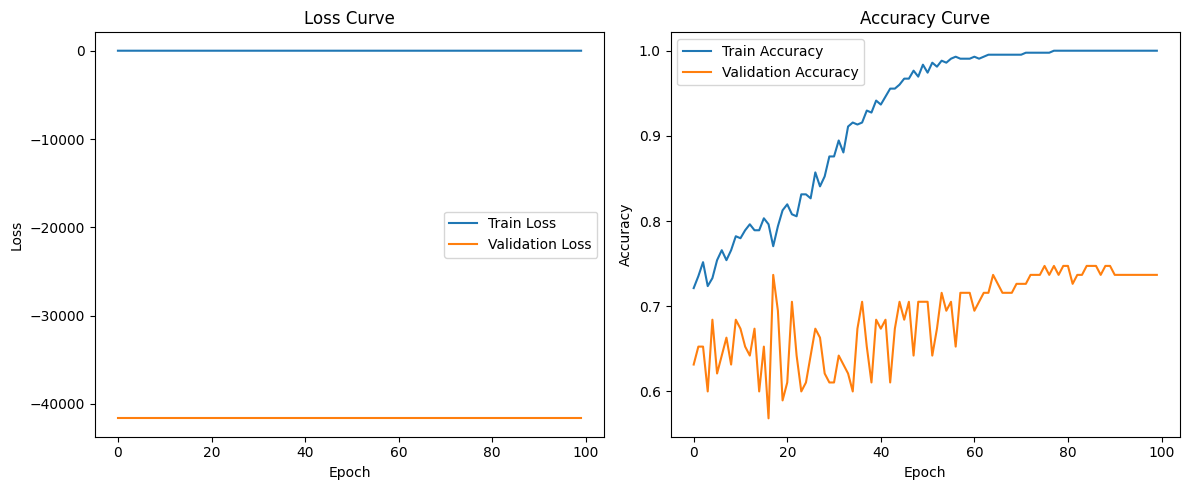

In [240]:
import matplotlib.pyplot as plt

# Assuming you tracked these metrics during training
# train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()
